In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,Ridge, RidgeCV,Lasso, LassoCV, ElasticNet,ElasticNetCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

In [2]:
amesprice= pd.read_csv("Ames_HousePrice.csv")
amesreal= pd.read_csv("Ames Real Estate Data.csv", dtype='object', index_col = 0)

In [3]:
amesreal.head()

,GeoRefNo,Tier,Range,Prop_Addr,ZngCdPr,ZngCdSc,ZngOLPr,ZngOLSc,ClassPr_S,ClassSc_S,...,PA-Nmbr,PA-PreD,PA-Strt,PA-StSfx,PA-PostD,PA-UnTyp,PA-UntNo,Date,Source,NmbrBRs
MapRefNo,,,,,,,,,,,,,,,,,,,,,
520400001,0520400001,0,0,4599 GEORGE W CARVER AVE,FS-RL,NaN,NaN,NaN,RESIDENTIAL,VACANT LAND - IMPROVED OR UNIMPROVED,...,4599,NaN,GEORGE W CARVER,AVE,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,NaN
520440010,0520440010,0,0,4507 EVEREST AVE,FS-RL,NaN,NaN,NaN,RESIDENTIAL,VACANT LAND - IMPROVED OR UNIMPROVED,...,4507,NaN,EVEREST,AVE,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,NaN
520440020,0520440020,0,0,4513 EVEREST AVE,FS-RL,NaN,NaN,NaN,RESIDENTIAL,VACANT LAND - IMPROVED OR UNIMPROVED,...,4513,NaN,EVEREST,AVE,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,NaN
520445001,0520445001,0,0,3449 BARCELOS ST,FS-RL,NaN,NaN,NaN,RESIDENTIAL,ASSOCIATION COMMON AREA,...,3449,NaN,BARCELOS,ST,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,NaN
520445010,0520445010,0,0,4506 EVEREST AVE,FS-RL,NaN,NaN,NaN,RESIDENTIAL,VACANT LAND - IMPROVED OR UNIMPROVED,...,4506,NaN,EVEREST,AVE,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,NaN


In [4]:
amesprice.head()

,Unnamed: 0,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,909176150,856,126000,30,RL,NaN,7890,Pave,NaN,...,166,0,NaN,NaN,NaN,0,3,2010,WD,Normal
1,2,905476230,1049,139500,120,RL,42.0,4235,Pave,NaN,...,0,0,NaN,NaN,NaN,0,2,2009,WD,Normal
2,3,911128020,1001,124900,30,C (all),60.0,6060,Pave,NaN,...,0,0,NaN,NaN,NaN,0,11,2007,WD,Normal
3,4,535377150,1039,114000,70,RL,80.0,8146,Pave,NaN,...,111,0,NaN,NaN,NaN,0,5,2009,WD,Normal
4,5,534177230,1665,227000,60,RL,70.0,8400,Pave,NaN,...,0,0,NaN,NaN,NaN,0,11,2009,WD,Normal


# Cleaning the Data

In [5]:
amesprice.info()
amesreal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     2580 non-null   int64  
 1   PID            2580 non-null   int64  
 2   GrLivArea      2580 non-null   int64  
 3   SalePrice      2580 non-null   int64  
 4   MSSubClass     2580 non-null   int64  
 5   MSZoning       2580 non-null   object 
 6   LotFrontage    2118 non-null   float64
 7   LotArea        2580 non-null   int64  
 8   Street         2580 non-null   object 
 9   Alley          168 non-null    object 
 10  LotShape       2580 non-null   object 
 11  LandContour    2580 non-null   object 
 12  Utilities      2580 non-null   object 
 13  LotConfig      2580 non-null   object 
 14  LandSlope      2580 non-null   object 
 15  Neighborhood   2580 non-null   object 
 16  Condition1     2580 non-null   object 
 17  Condition2     2580 non-null   object 
 18  BldgType

FireplaceQu    48.100775
Fence          79.651163
Alley          93.488372
MiscFeature    96.240310
PoolQC         99.651163
dtype: float64


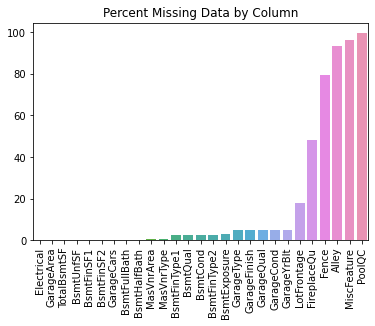

In [6]:
#figure out which columns to get rid of if too many null values

def percent_null(amesprice):
    percentmis = 100* amesprice.isnull().sum() / len(amesprice)
    return percentmis
percentmis=percent_null(amesprice)


percentmis = percentmis[percentmis>0].sort_values()
sns.barplot(x= percentmis.index, y=percentmis).set(title='Percent Missing Data by Column')
plt.xticks(rotation=90)
print(percentmis[percentmis>=20])

In [7]:
'''

Data Cleaning- seeing null variables and which should be filled in or dropped

Dropped Contenders
LotFrontage      is approx. 20% null and has similar info to LotArea. could be dropped
Alley            is mostly null and should be dropped
FireplaceQu      1241
Fence            2055
MiscFeature      2483

Fillna contenders

MasVnrType       should have nulls filled
Electrical-1 null
BsmtFullBath        2
BsmtHalfBath        2

Interesting that theres so many basement variables- are all necessary?
BsmtQual           69
BsmtCond           69
BsmtExposure       71
BsmtFinType1       69
BsmtFinSF1          1
BsmtFinType2       70
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1

GarageType        127
GarageYrBlt       129
GarageFinish      129
GarageCars          1
GarageArea          1
GarageQual        129
GarageCond        129
'''

#filling in the missing nulls
amesprice['MasVnrType']=amesprice['MasVnrType'].replace(np.nan, 'None')

#filling in missing values for ordinal features with NA
garagbaseordinal=['GarageType','GarageFinish','GarageQual','GarageCond','GarageYrBlt',
                  'BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
for x in garagbaseordinal:
    amesprice[x]=amesprice[x].replace(np.nan,'NA')

#filling in the missing values for nominal features with 0 (likely that there is no bsmt, garage,etc)    
garagenum=['GarageCars','GarageArea', 'BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF',
           'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea', 'TotalBsmtSF' ]
for y in garagenum:
    amesprice[y]=amesprice[y].replace(np.nan, 0)
    
amesprice.isnull().value_counts

<bound method DataFrame.value_counts of       Unnamed: 0    PID  GrLivArea  SalePrice  MSSubClass  MSZoning  \
0          False  False      False      False       False     False   
1          False  False      False      False       False     False   
2          False  False      False      False       False     False   
3          False  False      False      False       False     False   
4          False  False      False      False       False     False   
...          ...    ...        ...        ...         ...       ...   
2575       False  False      False      False       False     False   
2576       False  False      False      False       False     False   
2577       False  False      False      False       False     False   
2578       False  False      False      False       False     False   
2579       False  False      False      False       False     False   

      LotFrontage  LotArea  Street  Alley  ...  ScreenPorch  PoolArea  PoolQC  \
0            True    False

In [8]:
#dropping these columns because of excessive null values
amesprice.drop(['PoolQC','LotFrontage','Alley', 'FireplaceQu', 'Fence','MiscFeature', 'PID', 'Unnamed: 0'],
               inplace=True, axis=1)
#set the display of output table/dataframe to max columns
pd.set_option('display.max_columns',None)

In [9]:
for col in amesprice:
    print(col,amesprice[col].unique())

GrLivArea [ 856 1049 1001 ...  890 2002 1911]
SalePrice [126000 139500 124900 114000 227000 198500  93000 187687 137500 140000
 219500 136000  80000 159000 214000 163000 203000  67000 205000 131250
 181000 115000  98000 265979 105500 168165 201000 177500 200000 450000
  91300 173500 199500 207000 155000 220000 196000  61500 195000 129250
 291000 134000 186000 133500 148000 325300 215000 131000 109500 110000
 150000 193800 178000 179600 179000 395000 151500 341000 235000  72000
 154000 222000 390000 128200 615000 158000 254000 169000 284500 184500
 210400 392500 274725 156932 282922 144000  88000  67500 120000 134900
 185000 132500 160500 165000 100000 189900 227875 111900 145000 118000
 166000  99000  86000 211500 210000 228500 132000 468000 240000  73000
  75500 500067 330000 107500 172500 311872 165150 125000 159500 180500
 160000 109008 153000 132250 184900 127000 475000 142000 112000  80900
 135000 193500 232500 257000 117000 213000 212000 202500 185101 167000
 138500 102000 198900

# EDA of the Ames Saleprice Data

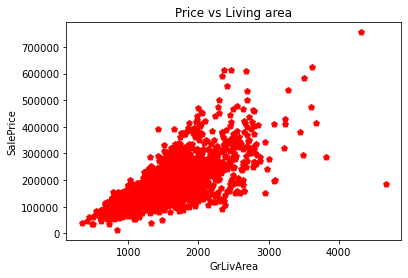

In [10]:
plt.scatter(amesprice.GrLivArea, amesprice.SalePrice, c = "red", marker = "p")
plt.title("Price vs Living area")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

In [11]:
print("minimum price: ",amesprice.SalePrice.min())
print("maximum price: ",amesprice.SalePrice.max())
print("average price: ",amesprice.SalePrice.mean())
print("median price: ",amesprice.SalePrice.median())
print("mode price: ",amesprice.SalePrice.mode())
#finding the minimum and max, mean, median and mode price to get an idea of the salesprice distribution

minimum price:  12789
maximum price:  755000
average price:  178059.62325581396
median price:  159900.0
mode price:  0    135000
dtype: int64


Text(0.5, 1.0, 'Distribution of Sales Price')

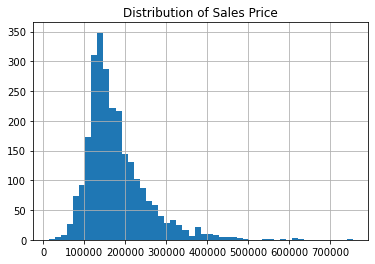

In [12]:
amesprice.SalePrice.hist(bins=50)
plt.title('Distribution of Sales Price')
#looking at the distribution of the prices- it is skewed and will need to be logged when we built the model

In [13]:
corr = amesprice.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

SalePrice        1.000000
OverallQual      0.790501
GrLivArea        0.719981
TotalBsmtSF      0.652494
1stFlrSF         0.642613
GarageCars       0.638424
GarageArea       0.634669
YearBuilt        0.544370
FullBath         0.534982
YearRemodAdd     0.514309
MasVnrArea       0.498432
TotRmsAbvGrd     0.490219
Fireplaces       0.488184
BsmtFinSF1       0.461070
WoodDeckSF       0.333232
OpenPorchSF      0.306540
BsmtFullBath     0.290755
HalfBath         0.285875
LotArea          0.274443
2ndFlrSF         0.263144
BsmtUnfSF        0.168060
BedroomAbvGr     0.151806
ScreenPorch      0.121463
3SsnPorch        0.031260
PoolArea         0.030844
BsmtFinSF2       0.022668
MoSold           0.012591
YrSold          -0.001376
MiscVal         -0.018877
LowQualFinSF    -0.030835
BsmtHalfBath    -0.033786
MSSubClass      -0.084587
OverallCond     -0.101091
KitchenAbvGr    -0.113977
EnclosedPorch   -0.123235
Name: SalePrice, dtype: float64


Text(0.5, 1.0, 'Pool Area vs. Sales Price')

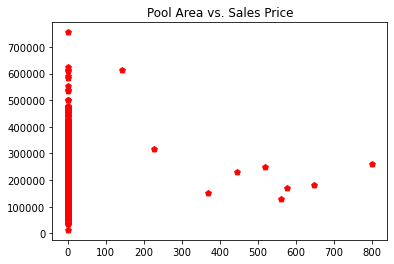

In [14]:
#just seeing if theres a relationship between having a pool and sales price
plt.scatter(amesprice.PoolArea, amesprice.SalePrice, c = "red", marker = "p")
plt.title('Pool Area vs. Sales Price')

In [15]:
amesprice.columns

Index(['GrLivArea', 'SalePrice', 'MSSubClass', 'MSZoning', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF',
       'OpenPorchSF', 

<AxesSubplot:>

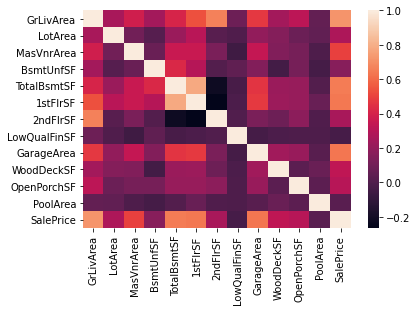

In [16]:
#Finding columns with size related data to compare to saleprice

size_related = amesprice.filter(regex='SF$|Area$')
corr = pd.concat([size_related, amesprice['SalePrice']], axis=1).corr()
sns.heatmap(corr)

In [17]:
print(corr[corr>0.5]) #0.5 to 0.7 is moderate correlation

#based on this- GrLivArea, TotalBsmtSF, 1stFlrSF, GarageArea have 
# the highest correllations with saleprice of the size related columns

              GrLivArea  LotArea  MasVnrArea  BsmtUnfSF  TotalBsmtSF  \
GrLivArea      1.000000      NaN         NaN        NaN          NaN   
LotArea             NaN      1.0         NaN        NaN          NaN   
MasVnrArea          NaN      NaN         1.0        NaN          NaN   
BsmtUnfSF           NaN      NaN         NaN        1.0          NaN   
TotalBsmtSF         NaN      NaN         NaN        NaN     1.000000   
1stFlrSF       0.539135      NaN         NaN        NaN     0.784271   
2ndFlrSF       0.665001      NaN         NaN        NaN          NaN   
LowQualFinSF        NaN      NaN         NaN        NaN          NaN   
GarageArea          NaN      NaN         NaN        NaN          NaN   
WoodDeckSF          NaN      NaN         NaN        NaN          NaN   
OpenPorchSF         NaN      NaN         NaN        NaN          NaN   
PoolArea            NaN      NaN         NaN        NaN          NaN   
SalePrice      0.719981      NaN         NaN        NaN     0.65

<AxesSubplot:xlabel='MasVnrArea', ylabel='SalePrice'>

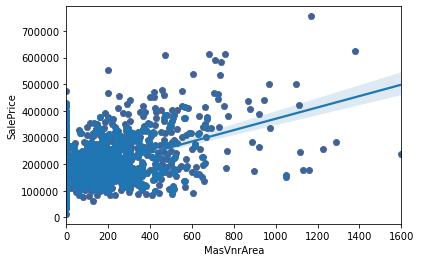

In [18]:
plt.scatter(amesprice.MasVnrArea, amesprice.SalePrice, c = "red", marker = "p")
sns.regplot(amesprice.MasVnrArea, amesprice.SalePrice)

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

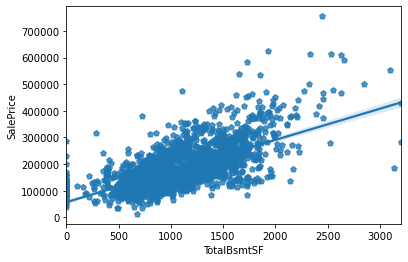

In [19]:
#plotting basement sf vs. saleprice- shows a correlation in houses with basements

sns.regplot(amesprice.TotalBsmtSF, amesprice.SalePrice, marker = "p")

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

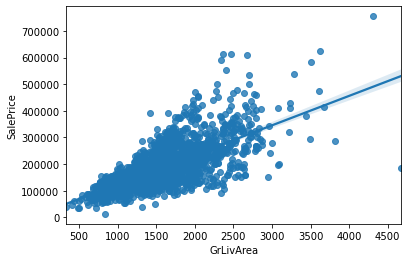

In [20]:
#plotting GrLivArea vs. Sale price- this column has highest correlation with saleprice 
sns.regplot(amesprice.GrLivArea, amesprice.SalePrice)

<AxesSubplot:xlabel='MSSubClass', ylabel='SalePrice'>

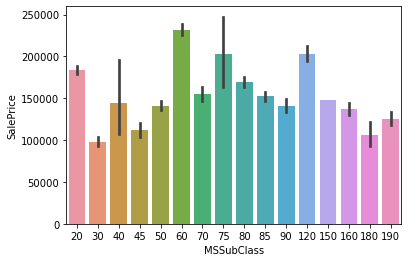

In [21]:
sns.barplot(x='MSSubClass', y='SalePrice', data=amesprice)
#  60	2-STORY 1946 & NEWER has the highest value

<AxesSubplot:xlabel='BldgType', ylabel='SalePrice'>

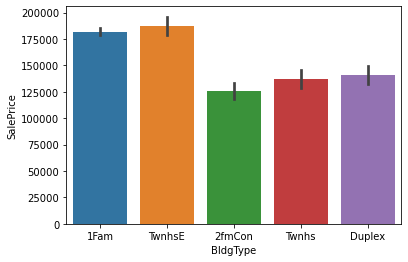

In [22]:
sns.barplot(x='BldgType', y='SalePrice', data=amesprice)
#Townhouse End Unit has highest avg followed by Single-family Detached

<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

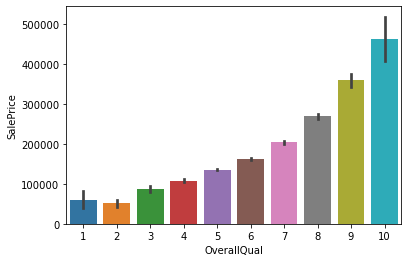

In [23]:
sns.barplot(x='OverallQual',y='SalePrice', data=amesprice)
#obviously higher quality material and finish homes sell for more

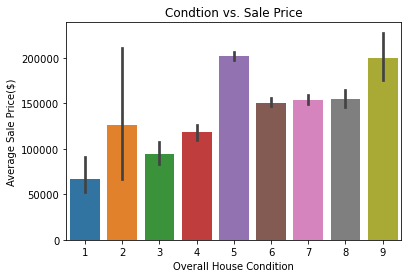

In [24]:
sns.barplot(x='OverallCond',y='SalePrice', data=amesprice).set(title="Condtion vs. Sale Price",xlabel='Overall House Condition', ylabel='Average Sale Price($)');
#average quality houses (rating 5) have a higher mean than 
#quality 9- lets look into this more more

Text(0.5, 1.0, 'Distribution of House Conditions')

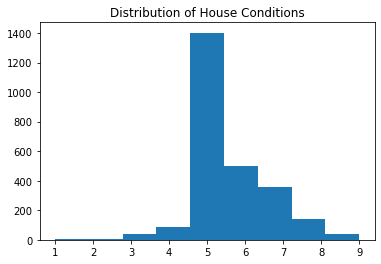

In [25]:
#looks like the majority of houses had a rating of 5 for the condition 
#which would skew the data
plt.hist(x=amesprice['OverallCond'], bins=9);
plt.title('Distribution of House Conditions')

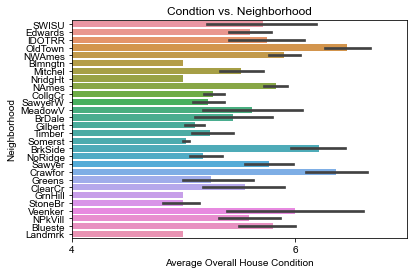

In [26]:
sns.barplot(y='Neighborhood', x='OverallCond', data=amesprice).set(title="Condtion vs. Neighborhood",xlabel='Average Overall House Condition', ylabel='Neighborhood')
plt.xlim(4, 7)
sns.set(rc={"figure.figsize":(10, 10)})
sns.set(font_scale=5)
#looks like certain neighborhoods have higher average condition ratings

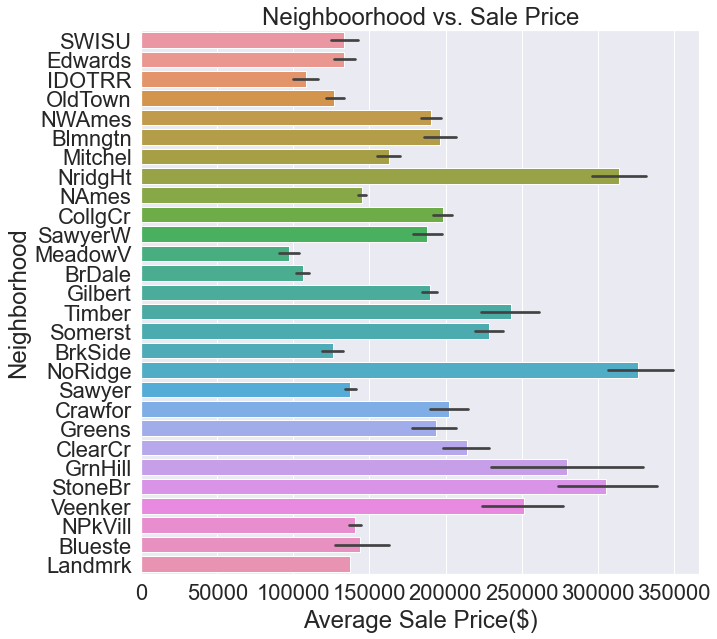

In [30]:
#find which neighborhoods cost more
sns.barplot(y='Neighborhood', x='SalePrice', data=amesprice).set(title="Neighboorhood vs. Sale Price",xlabel='Average Sale Price($)', ylabel='Neighborhood')
#plt.xticks(rotation=70)
sns.set(rc={"figure.figsize":(10, 10)})
sns.set(font_scale=2)
#Northridge Heights         NW- but lower avg condition rating
#Northridge                 NW - lower avg condition rating
#Stone Brook                NO - lower avg condition rating
#have the highest average price - 

#desirable neighborhoods are worth more than house condition

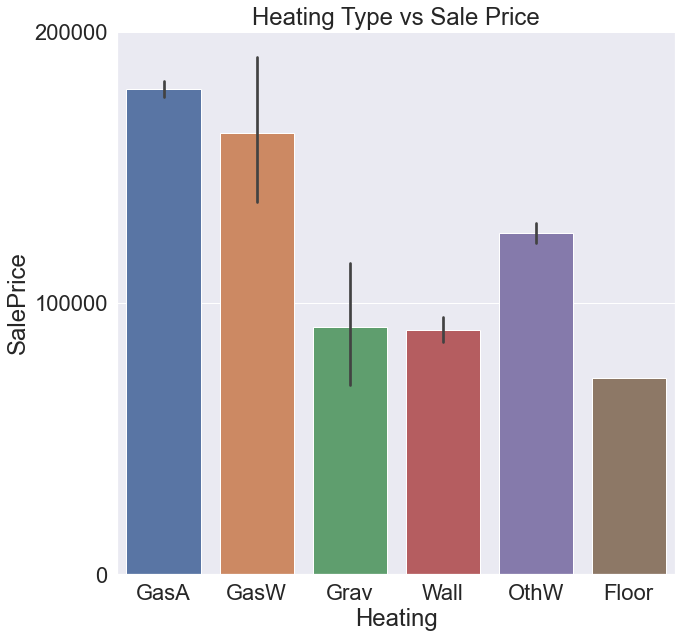

In [28]:
sns.barplot(x='Heating', y='SalePrice', data=amesprice).set(title='Heating Type vs Sale Price')
sns.set(font_scale=5)
#  GasA	Gas forced warm air furnace
#GasW	Gas hot water or steam heat

<AxesSubplot:xlabel='CentralAir', ylabel='SalePrice'>

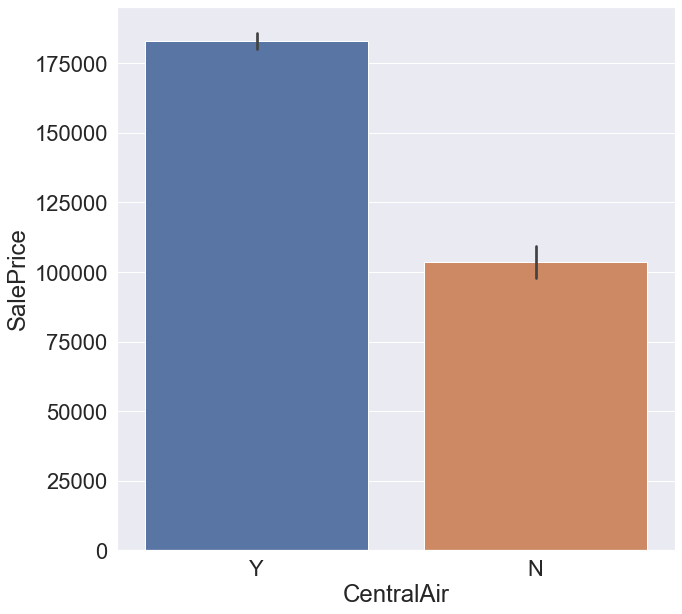

In [31]:
sns.barplot(x='CentralAir', y='SalePrice', data=amesprice)
#good contender for a binary codes variable later

<AxesSubplot:xlabel='1stFlrSF', ylabel='SalePrice'>

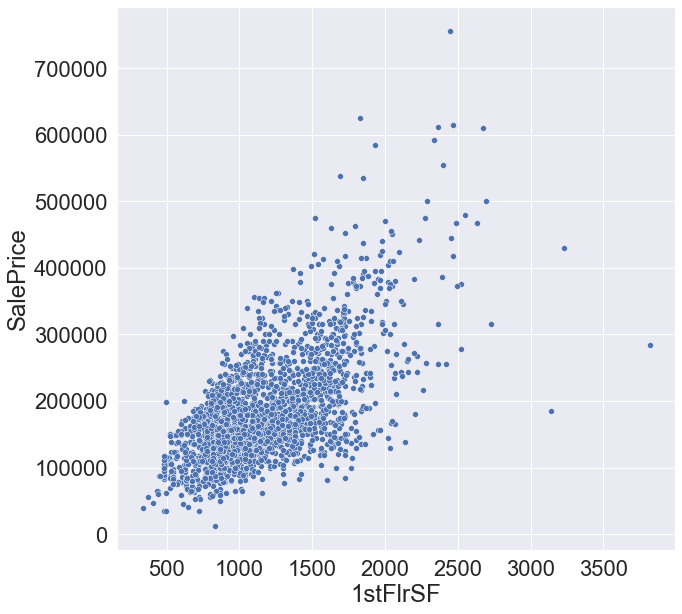

In [32]:
sns.scatterplot(x='1stFlrSF', y='SalePrice', data=amesprice)
#looking at 1stfloor footage vs saleprice since we've seen 
#there is a positive correlation

<AxesSubplot:>

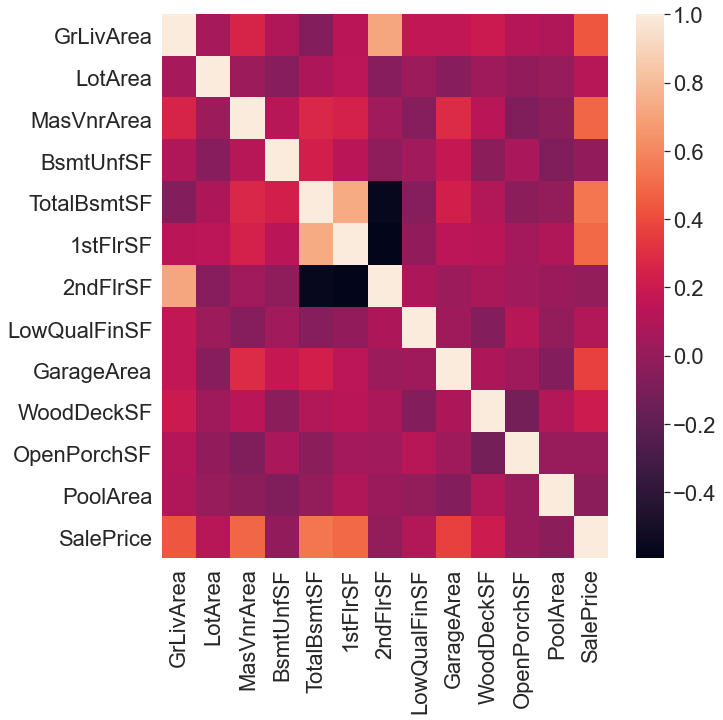

In [33]:
#trying to see if theres any correllations in the more expensive houses

expenhouse=amesprice.loc[(amesprice['SalePrice'] >= 250000)]
expenarea=expenhouse.filter(regex='SF$|Area$')

corr1 = pd.concat([expenarea, expenhouse['SalePrice']], axis=1).corr()
sns.heatmap(corr1)

In [34]:
print(corr1[corr1>0.5])
#in the more expensive houses theres a correllation for sales price
# with TotalBsmtSF & 1stFlrSF  

              GrLivArea  LotArea  MasVnrArea  BsmtUnfSF  TotalBsmtSF  \
GrLivArea      1.000000      NaN         NaN        NaN          NaN   
LotArea             NaN      1.0         NaN        NaN          NaN   
MasVnrArea          NaN      NaN         1.0        NaN          NaN   
BsmtUnfSF           NaN      NaN         NaN        1.0          NaN   
TotalBsmtSF         NaN      NaN         NaN        NaN     1.000000   
1stFlrSF            NaN      NaN         NaN        NaN     0.736775   
2ndFlrSF       0.715368      NaN         NaN        NaN          NaN   
LowQualFinSF        NaN      NaN         NaN        NaN          NaN   
GarageArea          NaN      NaN         NaN        NaN          NaN   
WoodDeckSF          NaN      NaN         NaN        NaN          NaN   
OpenPorchSF         NaN      NaN         NaN        NaN          NaN   
PoolArea            NaN      NaN         NaN        NaN          NaN   
SalePrice           NaN      NaN         NaN        NaN     0.54

In [35]:
import scipy.stats as st  #if it were normally distributed
st.t.interval(alpha=0.95, df=len(amesprice)-1, loc= 178059.62325581396, scale=st.sem(amesprice.SalePrice))

(175163.05773086424, 180956.18878076368)

<AxesSubplot:>

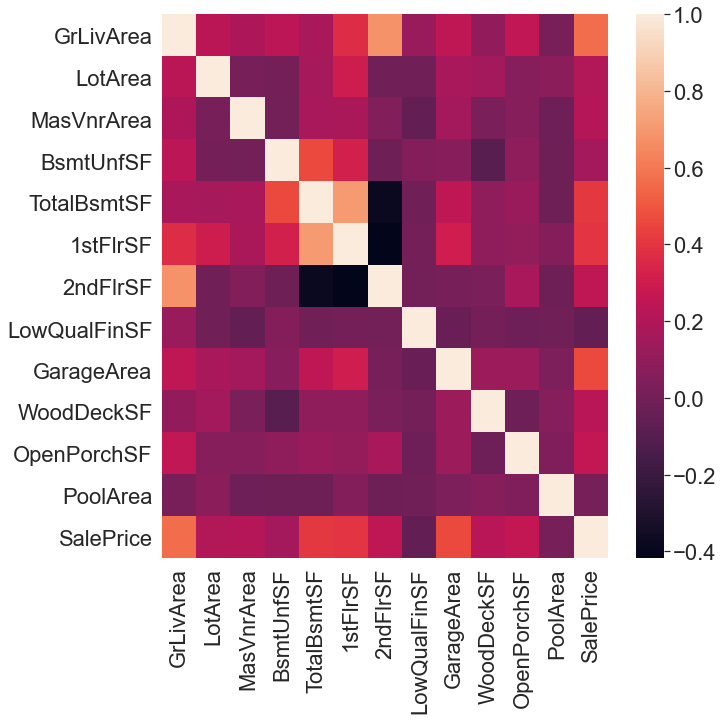

In [36]:
#making a dataframe of moderately priced homes to see their correlations

moderatehome= amesprice.loc[(amesprice['SalePrice'] < 250000) & (amesprice['SalePrice']>95000)]
modsize=moderatehome.filter(regex='SF$|Area$')

corr2 = pd.concat([modsize, moderatehome['SalePrice']], axis=1).corr()
sns.heatmap(corr2)

In [37]:
#finding which columns have a significant correlation with moderate home sales price
print(corr2[corr2>0.5])
#interesting that GarageArea has a correlation in moderately priced homes but not in expensive homes

              GrLivArea  LotArea  MasVnrArea  BsmtUnfSF  TotalBsmtSF  \
GrLivArea      1.000000      NaN         NaN        NaN          NaN   
LotArea             NaN      1.0         NaN        NaN          NaN   
MasVnrArea          NaN      NaN         1.0        NaN          NaN   
BsmtUnfSF           NaN      NaN         NaN        1.0          NaN   
TotalBsmtSF         NaN      NaN         NaN        NaN     1.000000   
1stFlrSF            NaN      NaN         NaN        NaN     0.711273   
2ndFlrSF       0.683273      NaN         NaN        NaN          NaN   
LowQualFinSF        NaN      NaN         NaN        NaN          NaN   
GarageArea          NaN      NaN         NaN        NaN          NaN   
WoodDeckSF          NaN      NaN         NaN        NaN          NaN   
OpenPorchSF         NaN      NaN         NaN        NaN          NaN   
PoolArea            NaN      NaN         NaN        NaN          NaN   
SalePrice      0.565006      NaN         NaN        NaN         

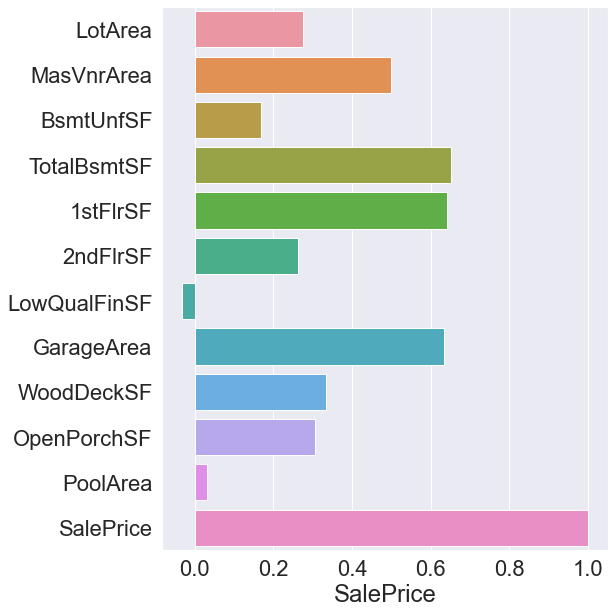

In [38]:
#looking at a bar plot of the different size related variables and their correlation
#with saleprice in relation to each other

corr3 = corr.sort_values('SalePrice', ascending=False)
plt.figure(figsize=(8,10))
sns.barplot( corr.SalePrice[1:], corr.index[1:], orient='h')
plt.show()

In [39]:
corr3 = amesprice.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

SalePrice       1.000000
GrLivArea       0.719981
TotalBsmtSF     0.652494
1stFlrSF        0.642613
GarageArea      0.634669
MasVnrArea      0.498432
WoodDeckSF      0.333232
OpenPorchSF     0.306540
LotArea         0.274443
2ndFlrSF        0.263144
BsmtUnfSF       0.168060
PoolArea        0.030844
LowQualFinSF   -0.030835
Name: SalePrice, dtype: float64


<AxesSubplot:xlabel='YrSold', ylabel='SalePrice'>

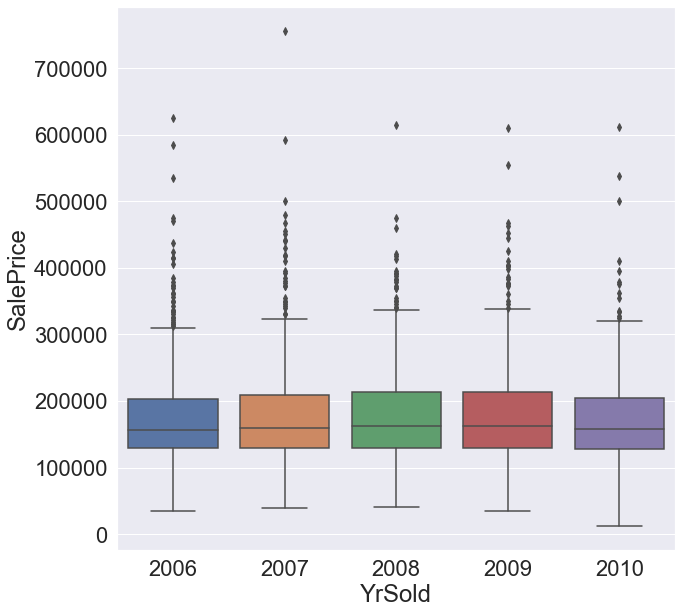

In [40]:
sns.boxplot(x=amesprice['YrSold'], y=amesprice['SalePrice'])

#trying to see if theres any trend in saleprice over time

MoSold
1     172500.0
2     166000.0
3     158000.0
4     153500.0
5     158000.0
6     159950.0
7     159217.0
8     165000.0
9     172000.0
10    151000.0
11    166000.0
12    166000.0
Name: SalePrice, dtype: float64


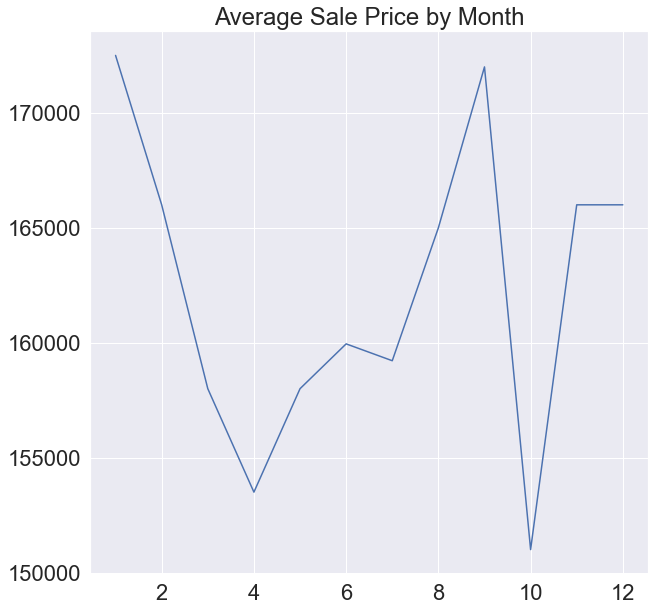

In [41]:
#looking for seasonal trends in saleprice based the on average saleprice in the month sold

mean_saleprice = amesprice.groupby('MoSold').median()['SalePrice']
plt.plot(mean_saleprice)
plt.title('Average Sale Price by Month')
print(mean_saleprice)

YrSold
2006    176649.310078
2007    179045.075000
2008    178170.021277
2009    180387.644444
2010    173971.666667
Name: SalePrice, dtype: float64


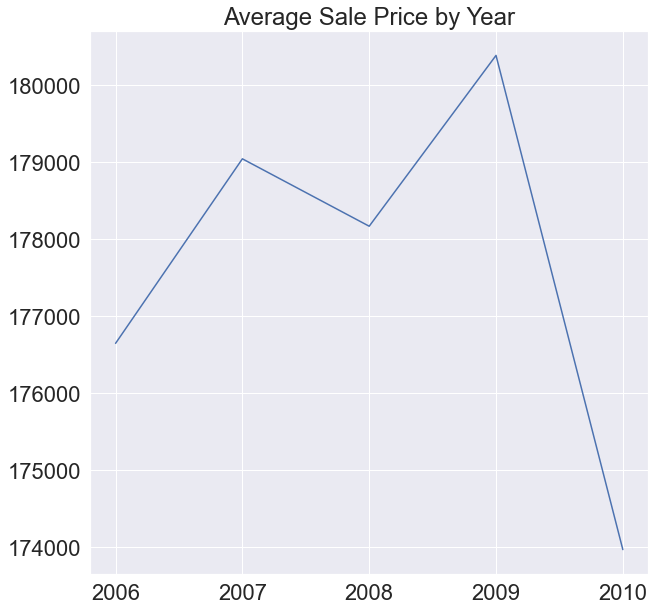

In [42]:
#looking at the average price by year--2008 recession
mean_saleprice = amesprice.groupby('YrSold').mean()['SalePrice']
plt.plot(mean_saleprice)
plt.title('Average Sale Price by Year')
print(mean_saleprice)

In [43]:
'''Looking at the average sale price by month and year sold'''
avgsaleprice = amesprice.groupby(['MoSold', 'YrSold']).mean()['SalePrice']
print(avgsaleprice)


MoSold  YrSold
1       2006      193051.666667
        2007      204752.750000
        2008      184847.666667
        2009      188005.812500
        2010      193368.238095
2       2006      188007.857143
        2007      163981.791667
        2008      193429.440000
        2009      171429.720000
        2010      171013.461538
3       2006      176295.300000
        2007      174905.978723
        2008      164235.818182
        2009      177780.813953
        2010      178828.413043
4       2006      164462.952381
        2007      161389.047619
        2008      160029.789474
        2009      184601.111111
        2010      166394.136364
5       2006      167335.522388
        2007      172200.226190
        2008      172453.026316
        2009      174817.126984
        2010      177211.041096
6       2006      172279.662921
        2007      182641.114583
        2008      185854.237624
        2009      188315.336735
        2010      173366.213333
7       2006      173263.

              BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  \
BsmtFinSF1      1.000000         NaN        NaN     0.512920      0.632841   
BsmtFinSF2           NaN         1.0        NaN          NaN           NaN   
BsmtUnfSF            NaN         NaN        1.0          NaN           NaN   
TotalBsmtSF     0.512920         NaN        NaN     1.000000           NaN   
BsmtFullBath    0.632841         NaN        NaN          NaN      1.000000   
BsmtHalfBath         NaN         NaN        NaN          NaN           NaN   
SalePrice            NaN         NaN        NaN     0.652494           NaN   

              BsmtHalfBath  SalePrice  
BsmtFinSF1             NaN        NaN  
BsmtFinSF2             NaN        NaN  
BsmtUnfSF              NaN        NaN  
TotalBsmtSF            NaN   0.652494  
BsmtFullBath           NaN        NaN  
BsmtHalfBath           1.0        NaN  
SalePrice              NaN   1.000000  
['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1'

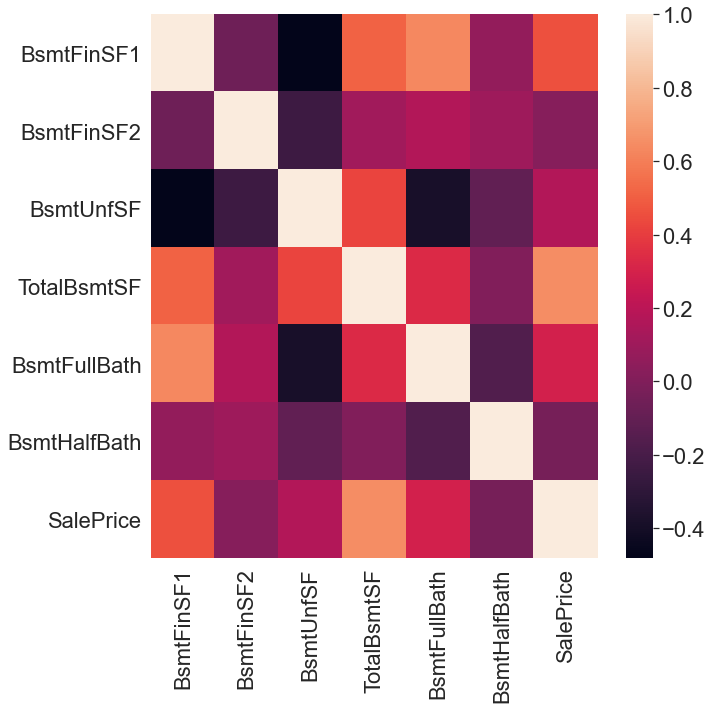

In [44]:
'''Looking at the basement columns originally null values- 
Seeing if theres any correlation of certain basement values with SalesPrice or with each other'''
                       
                       
basementfeat= [col for col in amesprice.columns if 'Bsmt' in col]  
corr4 = pd.concat([amesprice[basementfeat], amesprice['SalePrice']], axis=1).corr()
sns.heatmap(corr4)
print(corr4[corr4>0.5])
print(basementfeat)

In [ ]:
'''Looking at the garage features of the dataset and seeing if there is any correlation with 
other garage features or the sale price'''

garagefeat= [col for col in amesprice.columns if 'Garage' in col]
corr5 = pd.concat([amesprice[garagefeat], amesprice['SalePrice']], axis=1).corr()
sns.heatmap(corr5)
print(garagefeat)
print(corr4)

# Creating Features

In [45]:
'''Trying to simplify and combine some features'''

amesprice = amesprice.replace({"GarageCond" : {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                        "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "BsmtCond" : {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtQual" : {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}})

amesprice[["GarageCond", "GarageQual", "ExterCond","ExterQual","BsmtCond","BsmtQual","YrSold", "YearRemodAdd"]] = amesprice[["GarageCond", "GarageQual", "ExterCond","ExterQual", "BsmtCond","BsmtQual", "YrSold", "YearRemodAdd"]].apply(pd.to_numeric)

In [46]:
#condensing columns
#overall garage quality
amesprice["GarageGrade"] = amesprice["GarageQual"] * amesprice["GarageCond"]

# Overall quality of the exterior
amesprice["ExterGrade"] = amesprice["ExterQual"] * amesprice["ExterCond"]

#overall quality of basement
amesprice["BasementGrade"] = amesprice["BsmtQual"] * amesprice["BsmtCond"]

#total basement bathrooms= #full baths +#half baths
amesprice["TotalHouseBath"] = amesprice["BsmtFullBath"] + (0.5 * amesprice["BsmtHalfBath"])+amesprice["FullBath"] + (0.5 * amesprice["HalfBath"])

#total squarefootage of enclosedhouse (bsmt, garage, 1stfl, 2ndfl)
amesprice['TotalSqrFt']=amesprice['TotalBsmtSF']+amesprice['1stFlrSF']+amesprice['2ndFlrSF']+amesprice['GarageArea']

#age of remodel
amesprice['AgeofRemod'] = ((amesprice['YrSold'])-(amesprice['YearRemodAdd'])).apply(pd.to_numeric)

#age of house
amesprice['HouseAge'] = ((amesprice['YrSold'])-(amesprice['YearBuilt'])).apply(pd.to_numeric)
amesprice['YearBuilt']=pd.to_numeric(amesprice['YearBuilt'])

In [47]:
amesprice.skew(numeric_only=True)

'''A skewness value of 0 in the output denotes a symmetrical distribution of values in row 1.
A negative skewness value in the output indicates an asymmetry in the distribution and the tail 
is larger towards the left hand side of the distribution.
A positive skewness value in the output indicates an asymmetry in the distribution and the tail 
is larger towards the right hand side of the distribution.'''

'A skewness value of 0 in the output denotes a symmetrical distribution of values in row 1.\nA negative skewness value in the output indicates an asymmetry in the distribution and the tail \nis larger towards the left hand side of the distribution.\nA positive skewness value in the output indicates an asymmetry in the distribution and the tail \nis larger towards the right hand side of the distribution.'

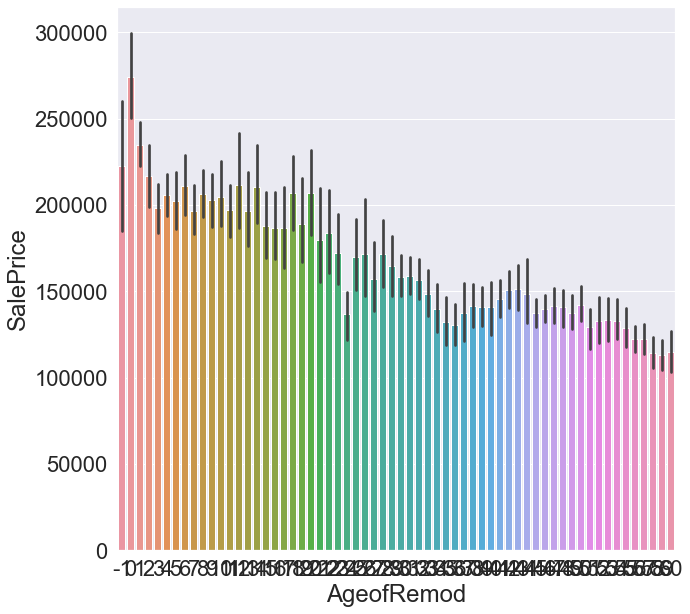

In [50]:
sns.barplot(x='AgeofRemod', y='SalePrice', data=amesprice)
sns.set(font_scale=2)
#shows that the more recently it was remodeled the higher the sale price

<AxesSubplot:xlabel='Fireplaces', ylabel='SalePrice'>

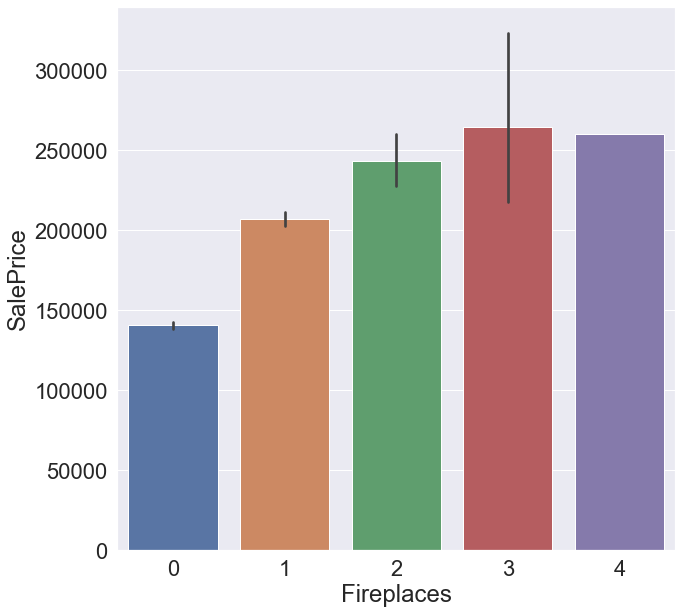

In [51]:
sns.barplot(x='Fireplaces', y='SalePrice', data=amesprice)
#shows that having a fireplace (any amount) increases the saleprice

In [ ]:
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

# Starting the Modeling Process for the AmesPrice dataframe


In [92]:
#Drop the columns affect our model- saleprice becoming Y var- type, condition, mosold and yrsold happen at 
#sale-data leakage- as well as columns that were previously condensed
amesprice1=amesprice.drop(['SalePrice', 'SaleType', 'SaleCondition','GarageYrBlt' ], axis=1)
                           
       #'BsmtFullBath','BsmtHalfBath',
                          #'FullBath', 'HalfBath'], axis=1)'''


In [93]:
#separate types of columns/features
categorical_features = amesprice1.select_dtypes(include = ["object"]).columns
numerical_features = amesprice1.select_dtypes(exclude = ["object"]).columns

#separating the features into dataframes
amesnum = amesprice1[numerical_features]
amescat = amesprice1[categorical_features]

amesnum.shape[1] 
amescat.shape[1] 

#seeing if theres any numericals in the wrong category before we scale and dummify
for col in amescat:
    print(col,amescat[col].unique())

MSZoning ['RL' 'C (all)' 'RM' 'FV' 'RH' 'I (all)' 'A (agr)']
Street ['Pave' 'Grvl']
LotShape ['Reg' 'IR1' 'IR3' 'IR2']
LandContour ['Lvl' 'Bnk' 'HLS' 'Low']
Utilities ['AllPub' 'NoSewr']
LotConfig ['Corner' 'Inside' 'FR2' 'CulDSac' 'FR3']
LandSlope ['Gtl' 'Mod' 'Sev']
Neighborhood ['SWISU' 'Edwards' 'IDOTRR' 'OldTown' 'NWAmes' 'Blmngtn' 'Mitchel'
 'NridgHt' 'NAmes' 'CollgCr' 'SawyerW' 'MeadowV' 'BrDale' 'Gilbert'
 'Timber' 'Somerst' 'BrkSide' 'NoRidge' 'Sawyer' 'Crawfor' 'Greens'
 'ClearCr' 'GrnHill' 'StoneBr' 'Veenker' 'NPkVill' 'Blueste' 'Landmrk']
Condition1 ['Norm' 'RRAn' 'PosN' 'Artery' 'RRAe' 'Feedr' 'PosA' 'RRNn' 'RRNe']
Condition2 ['Norm' 'PosN' 'Feedr' 'Artery' 'PosA' 'RRNn' 'RRAn' 'RRAe']
BldgType ['1Fam' 'TwnhsE' '2fmCon' 'Twnhs' 'Duplex']
HouseStyle ['1Story' '2Story' 'SFoyer' 'SLvl' '1.5Fin' '2.5Unf' '1.5Unf' '2.5Fin']
RoofStyle ['Gable' 'Hip' 'Mansard' 'Gambrel' 'Flat' 'Shed']
RoofMatl ['CompShg' 'Tar&Grv' 'WdShake' 'WdShngl' 'Metal' 'Roll' 'Membran']
Exterior1st ['Wd Sdn

In [94]:
ames1=amesprice1.copy()

In [95]:
from sklearn.preprocessing import RobustScaler
trans = RobustScaler()
ames1[numerical_features]= trans.fit_transform(ames1[numerical_features])


#attempt at scaling data for numerical columns

In [96]:
#dummify categorical features
dummies=pd.get_dummies(amescat, drop_first=True)

#assigning values to independent and dependent variables
x=pd.concat([ames1[numerical_features], dummies], axis=1)
y=amesprice['SalePrice']

In [97]:
x_train, x_test, y_train, y_test = train_test_split(x,np.log(y),test_size=0.3)

In [98]:
#running a simple linear regression on all the variables-will be poor due to number of variables
lm=LinearRegression()
lm.fit(x_train,y_train)
y_pred = lm.predict(x_test)
from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred))
print('The R2 for this training model is :',lm.score(x_train,y_train))
print('The R2 for this test model is :',lm.score(x_test, y_test))
print('The intercept for this model is:', lm.intercept_)
print('The coefficients for this model are:', lm.coef_)
print('The prediction with linear model:', lm.predict(x))

0.9239105740306512
The R2 for this training model is : 0.9337274604449408
The R2 for this test model is : 0.9239105740306512
The intercept for this model is: 11.340235723887748
The coefficients for this model are: [ 8.19590473e-02 -2.94027919e-02  7.92127471e-03  1.04148158e-01
  4.85301925e-02  3.71981306e-02  5.10333716e-03 -6.22057765e-04
 -1.56040785e-02 -2.30121149e-02  3.57232087e-02  1.99077352e-02
  2.83373095e-02  3.22318292e-05 -1.36458958e-02  2.73446083e-02
  4.09956303e-02  4.36933454e-02  4.75629753e-05  9.81034743e-03
 -7.56767288e-03  3.58179882e-03  1.63381569e-03 -2.71711696e-03
  4.99435309e-03  1.98393965e-02  2.39444022e-02  2.56126198e-02
  1.24368992e-04  6.59438493e-02  5.58864738e-02  2.01502067e-03
 -2.24794817e-03  1.31005208e-04  1.39995589e-04  2.09440580e-04
  6.12975209e-05  5.72461065e-06 -3.90896185e-03 -6.37338620e-03
 -1.56318031e-02  1.23507894e-02 -1.84283579e-02  1.04252176e-02
  5.60681067e-02 -5.43877854e-03 -3.74752344e-02 -2.07010574e-01
  2.07

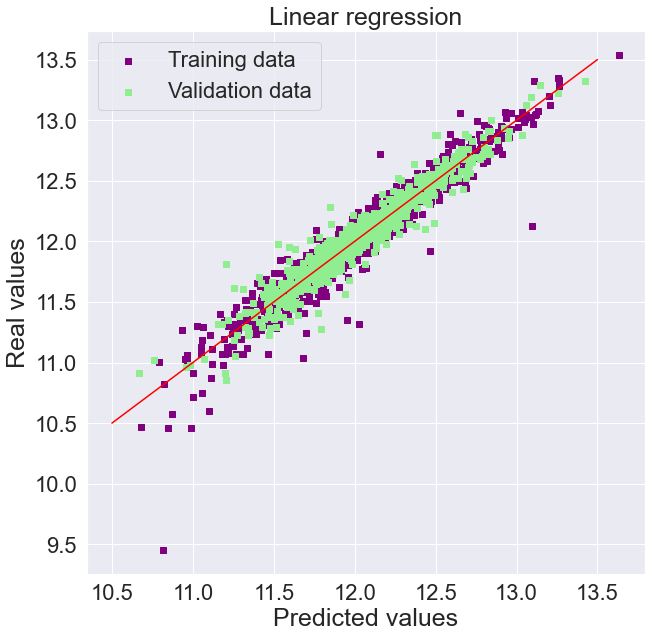

In [99]:
#would like to plot linear regression
y_train_pred = lm.predict(x_train)
y_test_pred = lm.predict(x_test)
plt.scatter(y_train_pred, y_train, c = "purple", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression", fontsize=25)
plt.xlabel("Predicted values",fontsize=25)
plt.ylabel("Real values", fontsize=25)
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

In [100]:
#calculating the statistical values for the ols model
import statsmodels.api as sm


x_add_const=sm.add_constant(x_train)
ols=sm.OLS(y_train, x_add_const)
ans=ols.fit()
print(ans.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     109.4
Date:                Wed, 09 Mar 2022   Prob (F-statistic):               0.00
Time:                        23:31:08   Log-Likelihood:                 1576.5
No. Observations:                1806   AIC:                            -2739.
Df Residuals:                    1599   BIC:                            -1601.
Df Model:                         206                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    8.6070 

# #Ridge Regression

In [101]:
'''Ridge Regression- performs better with large multivariate data with similar coefficients &
includes all predictors in the final model'''
#using RidgeCV model

alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60]
ridgecv = RidgeCV(alphas = alphas, normalize = False) #scoring = 'neg_mean_squared_error'
ridgecv.fit(x_train, y_train)
print('Best alpha:',ridgecv.alpha_)


y_pred = ridgecv.predict(x_test)
ridgecv.coef_
print('Train R2 with ridgecv',ridgecv.score(x_train, y_train))
print('Test R2 with ridgecv', ridgecv.score(x_test,y_test))
print(r2_score(y_test, y_pred))

'''
without log saleprice these are scores:
Best alpha: 0.06
Train R2 with ridge 0.9314275664890459
Test R2 with ridge 0.919731379463875
0.919731379463875'''

Best alpha: 10.0
Train R2 with ridgecv 0.926101903210202
Test R2 with ridgecv 0.9319135328630969
0.9319135328630969


'\nwithout log saleprice these are scores:\nBest alpha: 0.06\nTrain R2 with ridge 0.9314275664890459\nTest R2 with ridge 0.919731379463875\n0.919731379463875'

In [102]:
#using regular ridge model to find best alpha based on r values
alphas1=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006,0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60]
scorestrain={}
scorestest={}
#making the ridge model
for i in alphas1:
    ridge1 = Ridge(alpha = i, normalize = False)
    ridge1.fit(x_train, y_train)
    scorestrain[i]=ridge1.score(x_train, y_train)
    scorestest[i]=ridge1.score(x_test,y_test)

scorestrain=scorestrain.items()
scorestrain-list(scorestrain)
scorestrain=pd.DataFrame(scorestrain)
scorestest=scorestest.items()
scorestest-list(scorestest)
scorestest=pd.DataFrame(scorestest)
print(scorestrain)
print(scorestest)

          0         1
0    0.0001  0.933727
1    0.0003  0.933727
2    0.0006  0.933727
3    0.0010  0.933727
4    0.0030  0.933727
5    0.0060  0.933727
6    0.0100  0.933726
7    0.0300  0.933717
8    0.0600  0.933693
9    0.1000  0.933646
10   0.3000  0.933328
11   0.6000  0.932804
12   1.0000  0.932154
13   3.0000  0.929849
14   6.0000  0.927826
15  10.0000  0.926102
16  30.0000  0.921489
17  60.0000  0.917489
          0         1
0    0.0001  0.923913
1    0.0003  0.923919
2    0.0006  0.923927
3    0.0010  0.923938
4    0.0030  0.923992
5    0.0060  0.924071
6    0.0100  0.924174
7    0.0300  0.924651
8    0.0600  0.925266
9    0.1000  0.925942
10   0.3000  0.927991
11   0.6000  0.929386
12   1.0000  0.930259
13   3.0000  0.931468
14   6.0000  0.931817
15  10.0000  0.931914
16  30.0000  0.931642
17  60.0000  0.930809


In [103]:
ridge=Ridge(alpha=.6, normalize=False)
ridge.fit(x_train, y_train)
print(ridge.score(x_train, y_train))
print(ridge.score(x_test,y_test))
y_pred=ridge.predict(x_test)
r2_score(y_test,y_pred)
y_pred
'''
withoutlog saleprice these are values
0.9338693997258003
0.9203584447647076'''

0.932803892312177
0.9293861706034607


'\nwithoutlog saleprice these are values\n0.9338693997258003\n0.9203584447647076'

In [104]:
#finding the important features
coeffs =  np.abs(ridgecv.coef_) 
print('shrunk coef columns:',np.array(x.columns)[coeffs==0])
print('-'*100)
print('important features:',np.array(x.columns)[coeffs>0])

shrunk coef columns: ['MSZoning_I (all)' 'Condition2_RRAe' 'RoofMatl_Membran' 'RoofMatl_Metal']
----------------------------------------------------------------------------------------------------
important features: ['GrLivArea' 'MSSubClass' 'LotArea' 'OverallQual' 'OverallCond'
 'YearBuilt' 'YearRemodAdd' 'MasVnrArea' 'ExterQual' 'ExterCond'
 'BsmtQual' 'BsmtCond' 'BsmtFinSF1' 'BsmtFinSF2' 'BsmtUnfSF' 'TotalBsmtSF'
 '1stFlrSF' '2ndFlrSF' 'LowQualFinSF' 'BsmtFullBath' 'BsmtHalfBath'
 'FullBath' 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr' 'TotRmsAbvGrd'
 'Fireplaces' 'GarageCars' 'GarageArea' 'GarageQual' 'GarageCond'
 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch' '3SsnPorch' 'ScreenPorch'
 'PoolArea' 'MiscVal' 'MoSold' 'YrSold' 'GarageGrade' 'ExterGrade'
 'BasementGrade' 'TotalHouseBath' 'TotalSqrFt' 'AgeofRemod' 'HouseAge'
 'MSZoning_C (all)' 'MSZoning_FV' 'MSZoning_RH' 'MSZoning_RL'
 'MSZoning_RM' 'Street_Pave' 'LotShape_IR2' 'LotShape_IR3' 'LotShape_Reg'
 'LandContour_HLS' 'LandContour_L

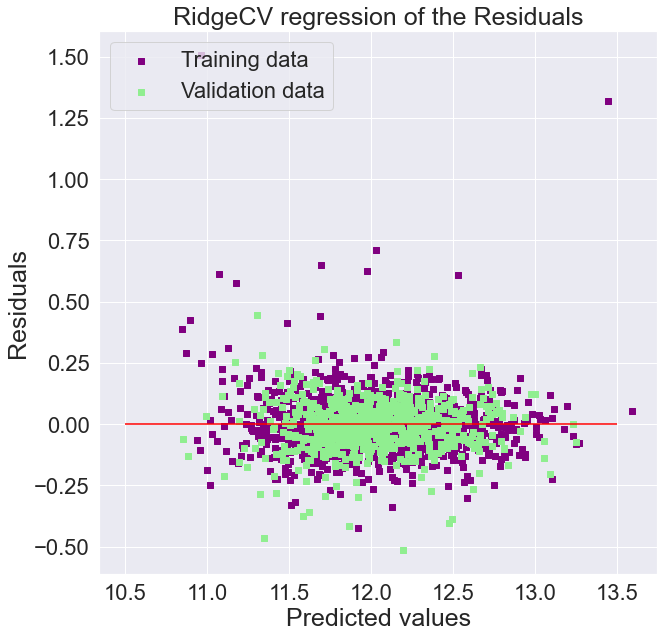

In [105]:
y_train_pred = ridgecv.predict(x_train)
y_test_pred = ridgecv.predict(x_test)

# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "purple", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("RidgeCV regression of the Residuals",fontsize=25)
plt.xlabel("Predicted values", fontsize=25)
plt.ylabel("Residuals", fontsize=25)
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

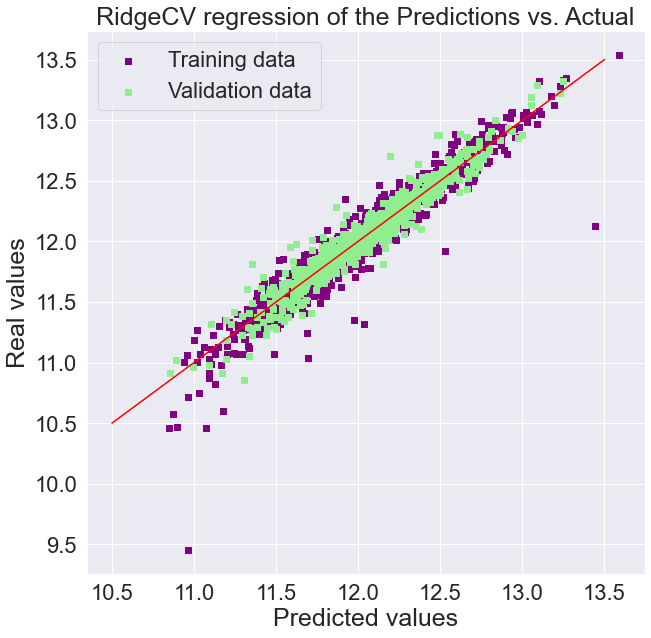

In [106]:
plt.scatter(y_train_pred, y_train, c = "purple", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("RidgeCV regression of the Predictions vs. Actual", fontsize=25)
plt.xlabel("Predicted values", fontsize=25)
plt.ylabel("Real values", fontsize=25)
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

Ridge picked 214 features and eliminated the other 4 features


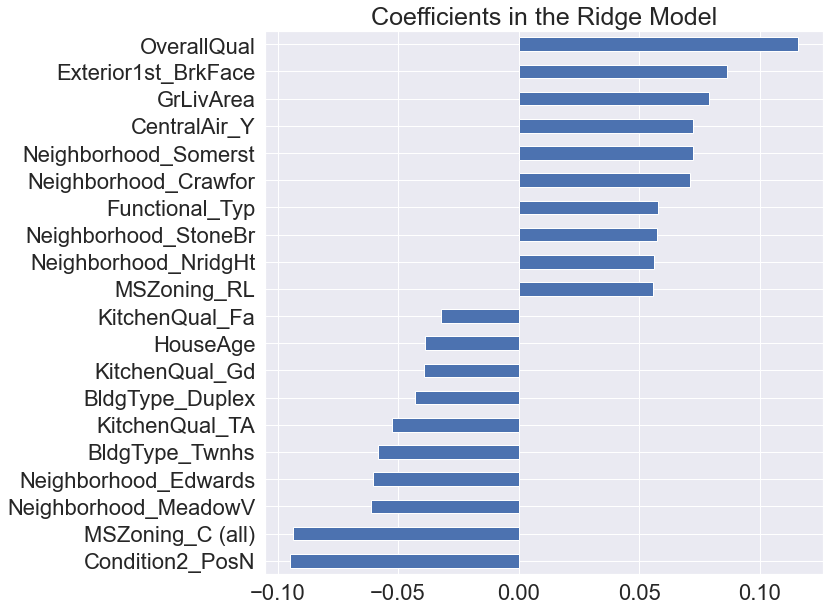

In [107]:
coefsridge = pd.Series(ridgecv.coef_, index = x_train.columns)
print("Ridge picked " + str(sum(coefsridge != 0)) + " features and eliminated the other " +  \
      str(sum(coefsridge == 0)) + " features")
imp_coefs = pd.concat([coefsridge.sort_values().head(10),
                     coefsridge.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model",fontsize=25)
plt.show()

# #Lasso Regression CV

In [108]:
'''Lasso Regression- coeff. with minor contributions to model=0
Does variable/feature selection to decrease complexity of the model'''
#running a regular lassocv and finding best alpha

lassocv = LassoCV(alphas = alphas, cv = 1000, max_iter = 100000, normalize = False)
lassocv.fit(x_train, y_train)
print('Best alpha:',lassocv.alpha_)
print('Train R2 with lassocv',lassocv.score(x_train, y_train)) 
print('Test R2 with lassocv', lassocv.score(x_test,y_test))

#running a regular lasso with the best alpha to compare the r^2
lasso=Lasso(alpha=0.0006, max_iter = 100000, normalize = False)
lasso.fit(x_train, y_train)

print('Train R2 with lasso',lasso.score(x_train, y_train))
print('Test R2 with lasso', lasso.score(x_test,y_test))

#finding the important features
coeffs =  np.abs(lassocv.coef_) 
print('shrunk coef columns:',np.array(x.columns)[coeffs==0])
print('-'*100)
print('important features:',np.array(x.columns)[coeffs>0])

'''without log saleprice: these are values
Best alpha: 3.0
Train R2 with lassocv 0.933680920822959
Test R2 with lassocv 0.9204576301722249
Train R2 with lasso 0.933680920822959
Test R2 with lasso 0.9204576301722249
'''

Best alpha: 0.0006
Train R2 with lassocv 0.9191370345819823
Test R2 with lassocv 0.9298022467568674
Train R2 with lasso 0.9191370345819823
Test R2 with lasso 0.9298022467568674
shrunk coef columns: ['YearBuilt' 'YearRemodAdd' 'BsmtUnfSF' 'TotalBsmtSF' '2ndFlrSF'
 'BsmtHalfBath' 'FullBath' 'HalfBath' 'KitchenAbvGr' 'GarageArea'
 'GarageCond' 'OpenPorchSF' 'ExterGrade' 'MSZoning_I (all)' 'MSZoning_RH'
 'Street_Pave' 'LotShape_IR2' 'LotShape_IR3' 'LandContour_Low'
 'Utilities_NoSewr' 'LotConfig_FR2' 'LotConfig_FR3' 'LotConfig_Inside'
 'LandSlope_Sev' 'Neighborhood_Blueste' 'Neighborhood_BrDale'
 'Neighborhood_CollgCr' 'Neighborhood_Gilbert' 'Neighborhood_Greens'
 'Neighborhood_GrnHill' 'Neighborhood_IDOTRR' 'Neighborhood_Landmrk'
 'Neighborhood_Mitchel' 'Neighborhood_NPkVill' 'Neighborhood_OldTown'
 'Neighborhood_SWISU' 'Neighborhood_Timber' 'Neighborhood_Veenker'
 'Condition1_Feedr' 'Condition1_PosA' 'Condition1_PosN' 'Condition1_RRAe'
 'Condition1_RRAn' 'Condition1_RRNe' 'Condition1_RRN

'without log saleprice: these are values\nBest alpha: 3.0\nTrain R2 with lassocv 0.933680920822959\nTest R2 with lassocv 0.9204576301722249\nTrain R2 with lasso 0.933680920822959\nTest R2 with lasso 0.9204576301722249\n'

# Running 2nd lassocv with important features

In [ ]:
x[['GrLivArea', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2','ExterQual', 'BsmtQual', 'LowQualFinSF', 'KitchenAbvGr', 'TotRmsAbvGrd',
 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'EnclosedPorch','BsmtFullBath',
 '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold',
 'GarageGrade', 'BasementGrade', 'TotalSqrFt', 'AgeofRemod', 'HouseAge',
 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RL', 'MSZoning_RM',
 'LotShape_IR2', 'LandContour_HLS', 'LotConfig_FR2', 'Neighborhood_BrkSide',
 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards',
 'Neighborhood_MeadowV', 'Neighborhood_NAmes', 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt', 'Neighborhood_SawyerW', 'Neighborhood_Somerst',
 'Neighborhood_StoneBr', 'Condition1_Norm', 'Condition2_Norm',
 'Condition2_PosN', 'BldgType_Duplex', 'BldgType_Twnhs', 'HouseStyle_1Story',
 'HouseStyle_2Story', 'Exterior1st_BrkFace', 'Exterior1st_CemntBd',
 'Exterior1st_MetalSd', 'Exterior1st_VinylSd', 'Exterior2nd_CmentBd',
 'Exterior2nd_Wd Sdng', 'MasVnrType_Stone', 'Foundation_PConc',
 'BsmtExposure_Gd', 'BsmtExposure_Mn', 'BsmtExposure_No', 'BsmtFinType1_GLQ',
 'BsmtFinType1_LwQ', 'BsmtFinType2_Rec', 'Heating_GasW', 'HeatingQC_Fa',
 'HeatingQC_TA', 'CentralAir_Y', 'Electrical_SBrkr', 'KitchenQual_TA',
 'Functional_Typ', 'GarageType_Attchd', 'GarageFinish_RFn',
 'GarageFinish_Unf', 'PavedDrive_Y']]

In [113]:
lascvimp=x[['GrLivArea', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual' ,'BsmtCond', 'BsmtFinSF1',
 'BsmtFinSF2', '1stFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BedroomAbvGr',
 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageQual', 'WoodDeckSF',
 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold',
 'YrSold', 'GarageGrade', 'BasementGrade', 'TotalHouseBath', 'TotalSqrFt',
 'AgeofRemod', 'HouseAge', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RL',
 'MSZoning_RM', 'LotShape_Reg', 'LandContour_HLS', 'LandContour_Lvl',
 'LotConfig_CulDSac', 'LandSlope_Mod', 'Neighborhood_BrkSide',
 'Neighborhood_ClearCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards',
 'Neighborhood_MeadowV', 'Neighborhood_NAmes', 'Neighborhood_NWAmes',
 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_Sawyer',
 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr',
 'Condition1_Norm', 'Condition2_PosN', 'BldgType_2fmCon', 'BldgType_Duplex',
 'BldgType_Twnhs', 'HouseStyle_1Story', 'Exterior1st_BrkFace',
 'Exterior1st_MetalSd', 'Exterior1st_Plywood', 'Exterior1st_Stucco',
 'Exterior2nd_Plywood', 'Exterior2nd_VinylSd', 'MasVnrType_None',
 'Foundation_PConc', 'BsmtExposure_Gd', 'BsmtExposure_Mn', 'BsmtExposure_No',
 'BsmtFinType1_GLQ', 'BsmtFinType1_LwQ', 'BsmtFinType1_Rec',
 'BsmtFinType1_Unf', 'HeatingQC_Fa', 'HeatingQC_TA', 'CentralAir_Y',
 'KitchenQual_Gd', 'KitchenQual_TA', 'Functional_Typ', 'GarageType_Attchd',
 'GarageFinish_RFn', 'GarageFinish_Unf', 'PavedDrive_Y']]

In [114]:
X3_train, X3_test, Y3_train, Y3_test=train_test_split(lascvimp, np.log(y), test_size=.3)

In [115]:
lassocv2 = LassoCV(alphas = alphas, cv = 100, max_iter = 100000, normalize = False)
lassocv2.fit(X3_train, Y3_train)
print('Best alpha:',lassocv2.alpha_) #get 2.205
print('Train R2 with lassocv',lassocv2.score(X3_train, Y3_train)) 
print('Test R2 with lassocv', lassocv2.score(X3_test,Y3_test))

Best alpha: 0.0006
Train R2 with lassocv 0.9178822683166498
Test R2 with lassocv 0.9301998397045748


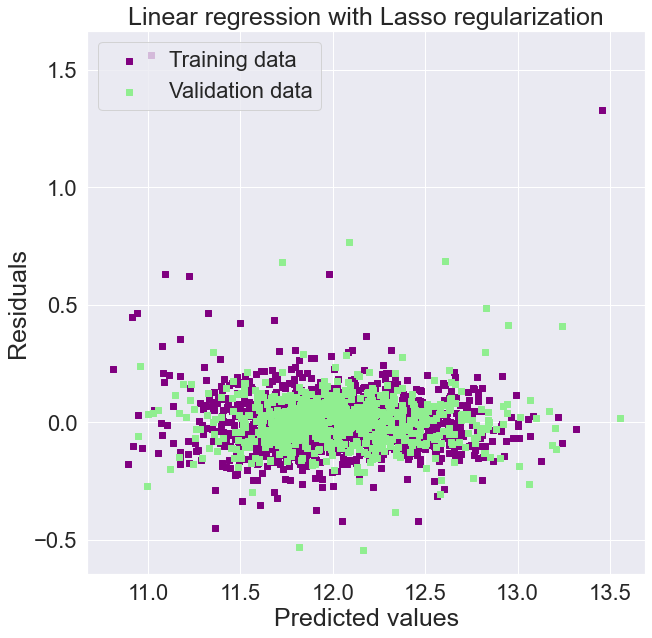

In [116]:
y_train_las2 =lassocv2.predict(X3_train)
y_test_las2 = lassocv2.predict(X3_test)

# Plot residuals
plt.scatter(y_train_las2, y_train_las2 - Y3_train, c = "purple", marker = "s", label = "Training data")
plt.scatter(y_test_las2, y_test_las2 - Y3_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization",fontsize=25)
plt.xlabel("Predicted values", fontsize=25)
plt.ylabel("Residuals",fontsize=25)
plt.legend(loc = "upper left")
plt.show()

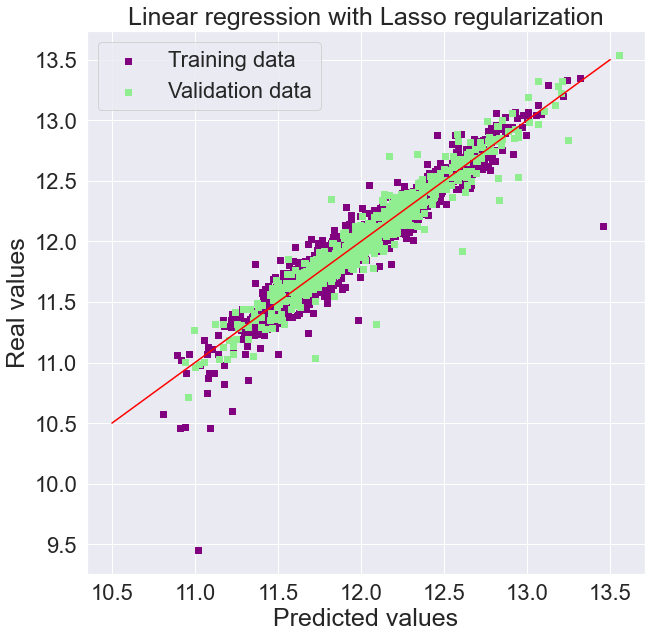

In [117]:
#plotting the predictions of the 2nd lassocv model with important features
plt.scatter(y_train_las2, Y3_train, c = "purple", marker = "s", label = "Training data")
plt.scatter(y_test_las2, Y3_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization", fontsize=25)
plt.xlabel("Predicted values", fontsize=25)
plt.ylabel("Real values", fontsize=25)
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

Lasso picked 76 features and eliminated the other 11 features


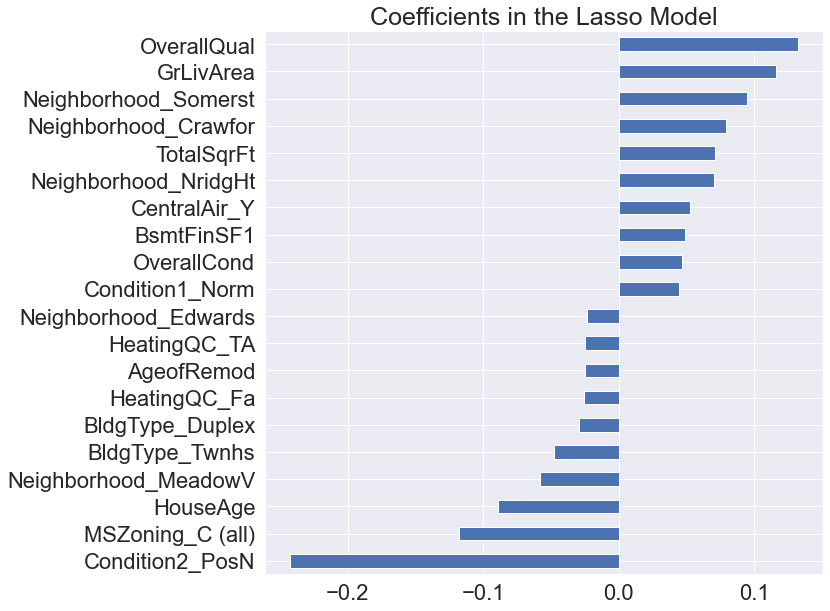

In [118]:
# Plot important coefficients
coefs2 = pd.Series(lassocv2.coef_, index = X3_train.columns)
print("Lasso picked " + str(sum(coefs2 != 0)) + " features and eliminated the other " +  \
      str(sum(coefs2 == 0)) + " features")
imp_coefs = pd.concat([coefs2.sort_values().head(10),
                     coefs2.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model", fontsize=25)
plt.show()

# lasso with gridsearch pipeline

In [119]:
'''Lasso Regression- coeff. with minor contributions to model=0
Does variable/feature selection to decrease complexity of the model'''
#only run when needed- takes time
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1., 5., 10., 25.], 'max_iter': [50000]}
lassopipe = GridSearchCV(Lasso(), cv=100, param_grid=param_grid, scoring='neg_mean_squared_error')

#lassopipe = GridSearchCV(Lasso(),{'model__alpha':np.arange(0.1,10,0.1)},
                     # cv = 1000, scoring="neg_mean_squared_error") #verbose=3)
                      
lassopipe.fit(x_train,y_train)


GridSearchCV(cv=100, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 5.0, 10.0,
                                   25.0],
                         'max_iter': [50000]},
             scoring='neg_mean_squared_error')

In [120]:
#finding all the important values from our pipeline lasso
print('train neg_mean_squared_error:',lassopipe.score(x_train,y_train))
print('train neg_mean_squared_error:',lassopipe.score(x_test,y_test))
y_pred=lassopipe.predict(x_test)
print('R2 score:',r2_score(y_test,y_pred)) #without logsaleprice=.91896

#finding the important features from the pipeline lasso
lassopipe.best_params_
coefficients = lassopipe.best_estimator_.coef_
#.named_steps['model']
importance = np.abs(coefficients)
print('These are important features:',np.array(x.columns)[importance > 0])
print('-'*100)
print('These features only minorly contributions to model:',np.array(x.columns)[importance == 0])

train neg_mean_squared_error: -0.013179150014209681
train neg_mean_squared_error: -0.010183220085675073
R2 score: 0.9273462805473908
These are important features: ['GrLivArea' 'MSSubClass' 'LotArea' 'OverallQual' 'OverallCond'
 'MasVnrArea' 'ExterQual' 'BsmtQual' 'BsmtCond' 'BsmtFinSF1' 'BsmtFinSF2'
 '1stFlrSF' 'LowQualFinSF' 'BsmtFullBath' 'BedroomAbvGr' 'TotRmsAbvGrd'
 'Fireplaces' 'GarageCars' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch'
 '3SsnPorch' 'ScreenPorch' 'PoolArea' 'MiscVal' 'MoSold' 'YrSold'
 'GarageGrade' 'BasementGrade' 'TotalHouseBath' 'TotalSqrFt' 'AgeofRemod'
 'HouseAge' 'MSZoning_C (all)' 'MSZoning_FV' 'MSZoning_RL' 'LotShape_Reg'
 'LandContour_HLS' 'Neighborhood_BrkSide' 'Neighborhood_Crawfor'
 'Neighborhood_Edwards' 'Neighborhood_MeadowV' 'Neighborhood_NridgHt'
 'Neighborhood_SawyerW' 'Neighborhood_Somerst' 'Condition1_Norm'
 'BldgType_Duplex' 'BldgType_Twnhs' 'Exterior1st_BrkFace'
 'Exterior1st_MetalSd' 'Exterior1st_Plywood' 'Exterior2nd_VinylSd'
 'Foundation_PConc

# Running 2nd lasso on the important features

In [121]:
x1=x[['GrLivArea','MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
 'LowQualFinSF', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
 'GarageCars', 'WoodDeckSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'GarageGrade', 'BasementGrade',
 'TotalHouseBath', 'TotalSqrFt', 'AgeofRemod', 'HouseAge', 'MSZoning_C (all)',
 'MSZoning_FV', 'MSZoning_RL', 'LandContour_HLS', 'Neighborhood_BrkSide',
 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards',
 'Neighborhood_MeadowV', 'Neighborhood_NAmes', 'Neighborhood_NridgHt',
 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr',
 'Condition1_Norm', 'BldgType_Duplex', 'BldgType_Twnhs', 'HouseStyle_1Story',
 'Exterior1st_BrkFace', 'Exterior1st_CemntBd', 'Exterior1st_MetalSd',
 'Exterior1st_VinylSd', 'Exterior2nd_CmentBd', 'Foundation_PConc',
 'BsmtExposure_Gd', 'BsmtExposure_Mn', 'BsmtExposure_No', 'BsmtFinType1_GLQ',
 'HeatingQC_Fa', 'HeatingQC_TA', 'CentralAir_Y', 'Electrical_SBrkr',
 'KitchenQual_TA', 'Functional_Typ', 'GarageType_Attchd', 'GarageFinish_Unf',
 'PavedDrive_Y']]

In [122]:
X2_train, X2_test, Y2_train, Y2_test=train_test_split(x1, np.log(y), test_size=.3)

In [123]:
lassocv1 = LassoCV(alphas = alphas, cv = 100, max_iter = 100000, normalize = False)
lassocv1.fit(X2_train, Y2_train)
print('Best alpha:',lassocv1.alpha_) #get 2.205
print('Train R2 with lassocv',lassocv1.score(X2_train, Y2_train)) 
print('Test R2 with lassocv', lassocv1.score(X2_test,Y2_test))

Best alpha: 0.0001
Train R2 with lassocv 0.9212190193337939
Test R2 with lassocv 0.9226730394822534


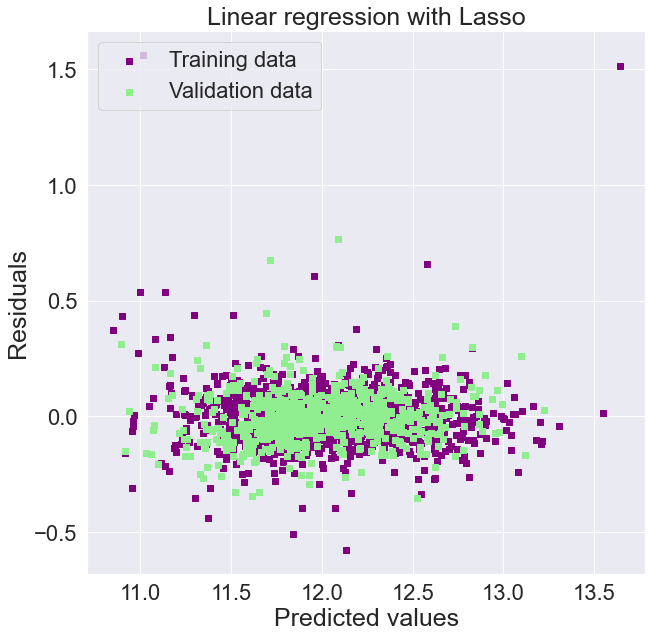

In [124]:

y_train_las1 =lassocv1.predict(X2_train)
y_test_las1 = lassocv1.predict(X2_test)

# Plot residuals
plt.scatter(y_train_las1, y_train_las1 - Y2_train, c = "purple", marker = "s", label = "Training data")
plt.scatter(y_test_las1, y_test_las1 - Y2_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso", fontsize=25)
plt.xlabel("Predicted values", fontsize=25)
plt.ylabel("Residuals", fontsize=25)
plt.legend(loc = "upper left")
plt.show()

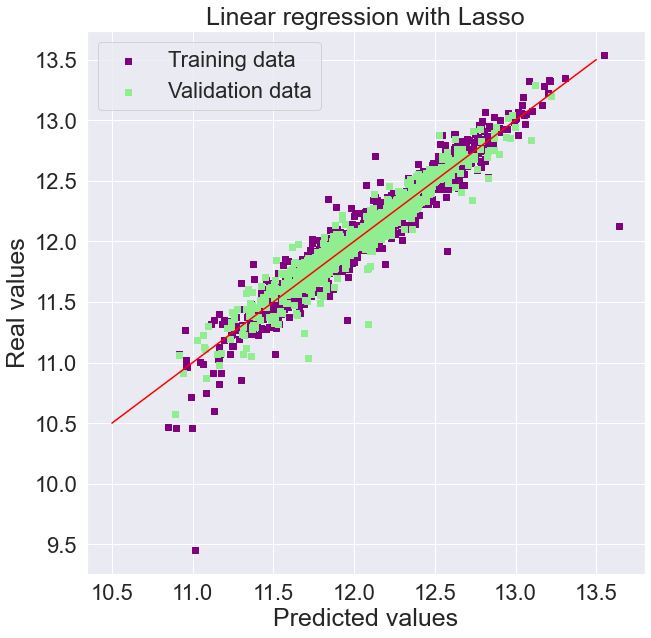

In [125]:
#plotting the predictions of the model
plt.scatter(y_train_las1, Y2_train, c = "purple", marker = "s", label = "Training data")
plt.scatter(y_test_las1, Y2_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso", fontsize=25)
plt.xlabel("Predicted values", fontsize=25)
plt.ylabel("Real values", fontsize=25)
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

Lasso picked 62 features and eliminated the other 2 features


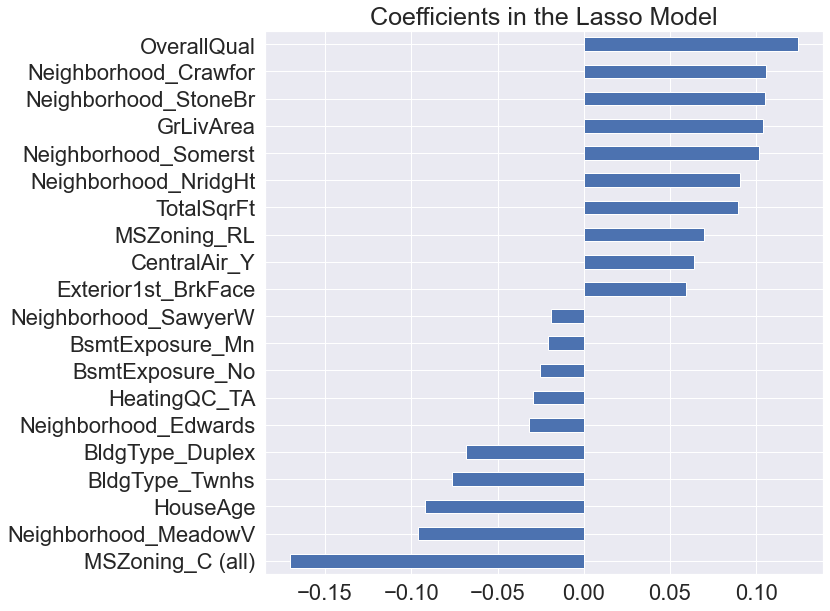

In [126]:
# Plot important coefficients of 2nd model
coefs1 = pd.Series(lassocv1.coef_, index = X2_train.columns)
print("Lasso picked " + str(sum(coefs1 != 0)) + " features and eliminated the other " +  \
      str(sum(coefs1 == 0)) + " features")
imp_coefs = pd.concat([coefs1.sort_values().head(10),
                     coefs1.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model", fontsize=25)
plt.show()

# #ElasticNet

In [127]:
'''Elastic Net- model penalized by both L1 norm and L2 norm

'''

elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 200, cv = 200)
elasticNet.fit(x_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )
print('elasticNetcv train score:', elasticNet.score(x_train, y_train))
print('elasticNetcv test score:', elasticNet.score(x_test, y_test))

'''these are scores without logged price
Best l1_ratio : 0.7
Best alpha : 0.006
train score: 0.9301990957445576
test score: 0.9251821991143977'''

Best l1_ratio : 0.1
Best alpha : 0.003
elasticNetcv train score: 0.9222394190139411
elasticNetcv test score: 0.9309321129588675


'these are scores without logged price\nBest l1_ratio : 0.7\nBest alpha : 0.006\ntrain score: 0.9301990957445576\ntest score: 0.9251821991143977'

In [128]:
#elasticNet.best_params_
coefficients1 = elasticNet.coef_
importance1 = np.abs(coefficients1)
print('These are important features for CV:',np.array(x.columns)[importance1 > 0])
print('-'*100)
print('These features only minorly contributions to model:',np.array(x.columns)[importance1 == 0])

These are important features for CV: ['GrLivArea' 'MSSubClass' 'LotArea' 'OverallQual' 'OverallCond'
 'YearBuilt' 'YearRemodAdd' 'MasVnrArea' 'ExterQual' 'ExterCond'
 'BsmtQual' 'BsmtCond' 'BsmtFinSF1' 'BsmtFinSF2' 'BsmtUnfSF' 'TotalBsmtSF'
 '1stFlrSF' '2ndFlrSF' 'LowQualFinSF' 'BsmtFullBath' 'BsmtHalfBath'
 'BedroomAbvGr' 'TotRmsAbvGrd' 'Fireplaces' 'GarageCars' 'GarageArea'
 'GarageQual' 'GarageCond' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch'
 '3SsnPorch' 'ScreenPorch' 'PoolArea' 'MiscVal' 'MoSold' 'YrSold'
 'GarageGrade' 'BasementGrade' 'TotalHouseBath' 'TotalSqrFt' 'AgeofRemod'
 'HouseAge' 'MSZoning_C (all)' 'MSZoning_FV' 'MSZoning_RL' 'MSZoning_RM'
 'LotShape_IR2' 'LotShape_Reg' 'LandContour_HLS' 'LandContour_Lvl'
 'LotConfig_CulDSac' 'LotConfig_FR2' 'LotConfig_Inside' 'LandSlope_Mod'
 'Neighborhood_BrkSide' 'Neighborhood_ClearCr' 'Neighborhood_Crawfor'
 'Neighborhood_Edwards' 'Neighborhood_Gilbert' 'Neighborhood_IDOTRR'
 'Neighborhood_MeadowV' 'Neighborhood_NAmes' 'Neighborhood_N

In [129]:
#Running the models with those values-regular elastic net
elasticnet1 = ElasticNet(alpha=.001, l1_ratio=0.1, normalize=False)
elasticnet1.fit(x_train, y_train)
print(r'The R^2  train regular elasticNet is %.4f' %(elasticnet1.score(x_train,y_train)))
print(r'The R^2  test is %.4f' %(elasticnet1.score(x_test,y_test)))
#elasticnet.coef_,  elasticnet.intercept_
'''
these are scores without logged saleprice
The R^2  train is 0.929
The R^2  test is 0.926'''

The R^2  train regular elasticNet is 0.9283
The R^2  test is 0.9321


'\nthese are scores without logged saleprice\nThe R^2  train is 0.929\nThe R^2  test is 0.926'

In [130]:
coefficients2 = elasticnet1.coef_
importance2 = np.abs(coefficients2)
print('These are important features:',np.array(x.columns)[importance2 > 0])
print('-'*100)
print('These features only minorly contributions to model:',np.array(x.columns)[importance2 == 0])

These are important features: ['GrLivArea' 'MSSubClass' 'LotArea' 'OverallQual' 'OverallCond'
 'YearBuilt' 'YearRemodAdd' 'MasVnrArea' 'ExterQual' 'ExterCond'
 'BsmtQual' 'BsmtCond' 'BsmtFinSF1' 'BsmtFinSF2' 'BsmtUnfSF' 'TotalBsmtSF'
 '1stFlrSF' '2ndFlrSF' 'LowQualFinSF' 'BsmtFullBath' 'BsmtHalfBath'
 'BedroomAbvGr' 'TotRmsAbvGrd' 'Fireplaces' 'GarageCars' 'WoodDeckSF'
 'OpenPorchSF' 'EnclosedPorch' '3SsnPorch' 'ScreenPorch' 'PoolArea'
 'MiscVal' 'MoSold' 'YrSold' 'GarageGrade' 'BasementGrade'
 'TotalHouseBath' 'TotalSqrFt' 'AgeofRemod' 'HouseAge' 'MSZoning_C (all)'
 'MSZoning_FV' 'MSZoning_RL' 'MSZoning_RM' 'LotShape_IR2' 'LotShape_Reg'
 'LandContour_HLS' 'LandContour_Lvl' 'LotConfig_CulDSac' 'LotConfig_FR2'
 'LotConfig_FR3' 'LandSlope_Mod' 'Neighborhood_Blueste'
 'Neighborhood_BrDale' 'Neighborhood_BrkSide' 'Neighborhood_ClearCr'
 'Neighborhood_CollgCr' 'Neighborhood_Crawfor' 'Neighborhood_Edwards'
 'Neighborhood_Gilbert' 'Neighborhood_Greens' 'Neighborhood_GrnHill'
 'Neighborhood_ID

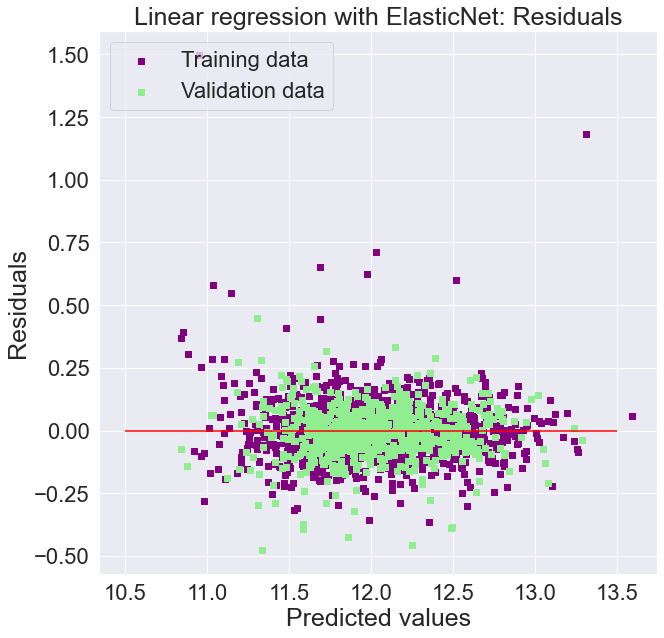

In [131]:
y_train_ela = elasticnet1.predict(x_train)
y_test_ela = elasticnet1.predict(x_test)

# Plot residuals
plt.scatter(y_train_ela, y_train_ela - y_train, c = "purple", marker = "s", label = "Training data")
plt.scatter(y_test_ela, y_test_ela - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet: Residuals", fontsize=25)
plt.xlabel("Predicted values", fontsize=25)
plt.ylabel("Residuals", fontsize=25)
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

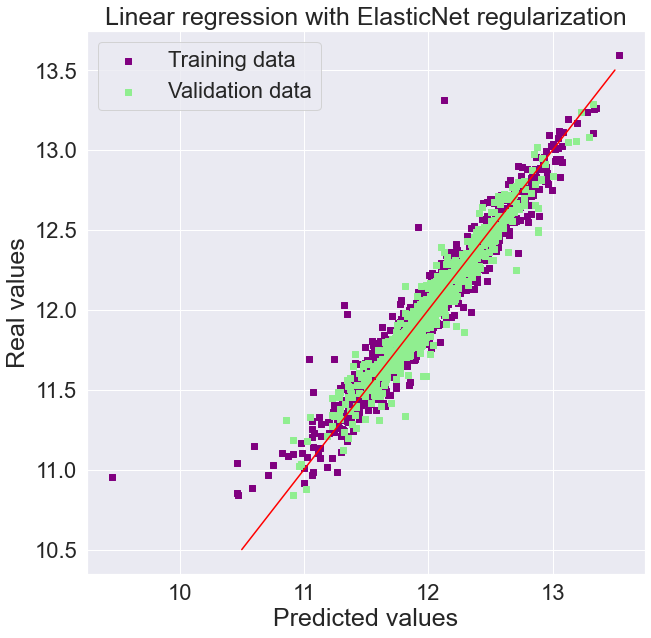

In [132]:
plt.scatter(y_train, y_train_ela, c = "purple", marker = "s", label = "Training data")
plt.scatter(y_test, y_test_ela, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization", fontsize=25)
plt.xlabel("Predicted values", fontsize=25)
plt.ylabel("Real values", fontsize=25)
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

ElasticNet picked 165 features and eliminated the other 53 features


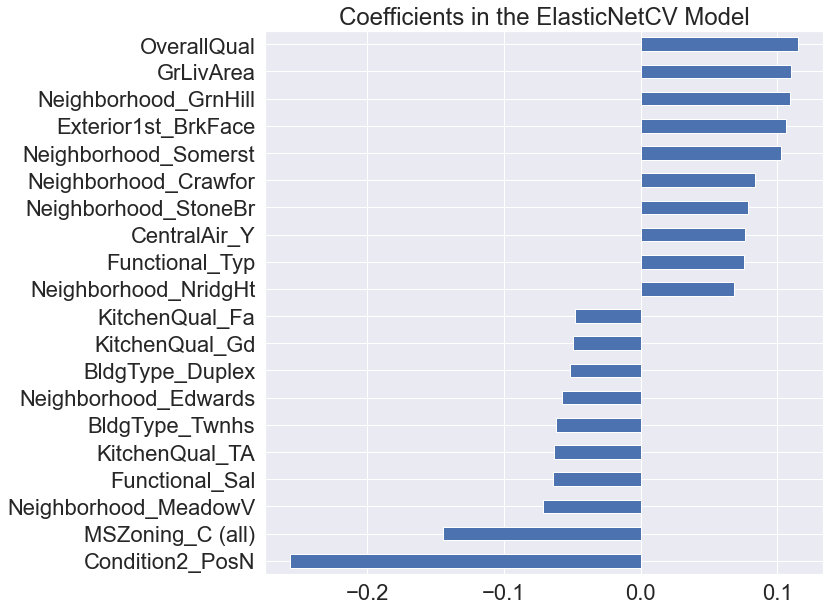

In [133]:
coefs = pd.Series(elasticnet1.coef_, index = x_train.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNetCV Model")
plt.show()

# Running second round elasticnet on important features to see if accuracy is improved

In [134]:
elasticimp=x[['GrLivArea', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond',
 'BsmtQual', 'BsmtCond', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
 '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath',
 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
 'GarageCars', 'GarageQual', 'GarageCond', 'WoodDeckSF', 'OpenPorchSF',
 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold',
 'YrSold', 'GarageGrade', 'BasementGrade', 'TotalHouseBath', 'TotalSqrFt',
 'AgeofRemod', 'HouseAge', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH',
 'MSZoning_RL', 'MSZoning_RM', 'Street_Pave', 'LotShape_IR2', 'LotShape_IR3',
 'LotShape_Reg', 'LandContour_HLS', 'LandContour_Lvl', 'Utilities_NoSewr',
 'LotConfig_FR2', 'LotConfig_FR3', 'LandSlope_Mod', 'LandSlope_Sev',
 'Neighborhood_Blueste', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr',
 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards',
 'Neighborhood_Gilbert', 'Neighborhood_Greens', 'Neighborhood_GrnHill',
 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes',
 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer',
 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr',
 'Neighborhood_Veenker', 'Condition1_Norm', 'Condition1_PosA',
 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition2_Norm',
 'Condition2_PosA', 'Condition2_PosN', 'BldgType_2fmCon', 'BldgType_Duplex',
 'BldgType_Twnhs', 'BldgType_TwnhsE', 'HouseStyle_1Story',
 'HouseStyle_2.5Unf', 'HouseStyle_2Story', 'HouseStyle_SFoyer',
 'RoofStyle_Gambrel', 'RoofStyle_Mansard', 'RoofMatl_Tar&Grv',
 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'Exterior1st_BrkComm',
 'Exterior1st_BrkFace', 'Exterior1st_MetalSd', 'Exterior1st_Plywood',
 'Exterior1st_PreCast', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng',
 'Exterior1st_WdShing', 'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn',
 'Exterior2nd_HdBoard', 'Exterior2nd_MetalSd', 'Exterior2nd_Plywood',
 'Exterior2nd_PreCast', 'Exterior2nd_Stucco', 'Exterior2nd_VinylSd',
 'Exterior2nd_Wd Sdng', 'MasVnrType_BrkFace', 'MasVnrType_Stone',
 'Foundation_CBlock', 'Foundation_PConc', 'Foundation_Stone',
 'Foundation_Wood', 'BsmtExposure_Gd', 'BsmtExposure_Mn', 'BsmtExposure_No',
 'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ', 'BsmtFinType1_LwQ',
 'BsmtFinType1_Rec', 'BsmtFinType1_Unf', 'BsmtFinType2_BLQ',
 'BsmtFinType2_GLQ', 'BsmtFinType2_LwQ', 'BsmtFinType2_Rec', 'Heating_GasA',
 'Heating_GasW', 'Heating_Grav', 'Heating_Wall', 'HeatingQC_Fa',
 'HeatingQC_Gd', 'HeatingQC_TA', 'CentralAir_Y', 'Electrical_SBrkr',
 'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA', 'Functional_Maj2',
 'Functional_Min1', 'Functional_Min2', 'Functional_Mod', 'Functional_Typ',
 'GarageType_Attchd', 'GarageType_Basment', 'GarageType_Detchd',
 'GarageType_NA', 'GarageFinish_NA', 'GarageFinish_RFn', 'GarageFinish_Unf',
 'PavedDrive_P', 'PavedDrive_Y']]

In [135]:
X4_train, X4_test, Y4_train, Y4_test=train_test_split(elasticimp, np.log(y), test_size=.3)

In [136]:
elasticNet4 = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 200, cv = 200)
elasticNet4.fit(X4_train, Y4_train)
alpha = elasticNet4.alpha_
ratio = elasticNet4.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )
print('elasticNetcv train score:', elasticNet4.score(X4_train, Y4_train))
print('elasticNetcv test score:', elasticNet4.score(X4_test, Y4_test))

Best l1_ratio : 0.1
Best alpha : 0.001
elasticNetcv train score: 0.933053551254708
elasticNetcv test score: 0.9063109661590535


In [137]:
coefficients4 = elasticNet4.coef_
importance4 = np.abs(coefficients4)
print('These are important features:',np.array(elasticimp.columns)[importance4 > 0])
print('-'*100)
print('These features only minorly contributions to model:',np.array(elasticimp.columns)[importance4 == 0])

These are important features: ['GrLivArea' 'MSSubClass' 'LotArea' 'OverallQual' 'OverallCond'
 'YearBuilt' 'YearRemodAdd' 'MasVnrArea' 'ExterQual' 'BsmtCond'
 'BsmtFinSF1' 'BsmtFinSF2' 'BsmtUnfSF' 'TotalBsmtSF' '1stFlrSF' '2ndFlrSF'
 'LowQualFinSF' 'BsmtFullBath' 'BsmtHalfBath' 'HalfBath' 'BedroomAbvGr'
 'KitchenAbvGr' 'TotRmsAbvGrd' 'Fireplaces' 'GarageCars' 'GarageCond'
 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch' '3SsnPorch' 'ScreenPorch'
 'PoolArea' 'MiscVal' 'MoSold' 'YrSold' 'GarageGrade' 'BasementGrade'
 'TotalHouseBath' 'TotalSqrFt' 'HouseAge' 'MSZoning_C (all)' 'MSZoning_FV'
 'MSZoning_RH' 'MSZoning_RL' 'MSZoning_RM' 'LotShape_Reg'
 'LandContour_HLS' 'LandContour_Lvl' 'Utilities_NoSewr' 'LotConfig_FR2'
 'LandSlope_Mod' 'Neighborhood_Blueste' 'Neighborhood_BrkSide'
 'Neighborhood_ClearCr' 'Neighborhood_CollgCr' 'Neighborhood_Crawfor'
 'Neighborhood_Edwards' 'Neighborhood_Gilbert' 'Neighborhood_Greens'
 'Neighborhood_GrnHill' 'Neighborhood_MeadowV' 'Neighborhood_Mitchel'
 'Neighb

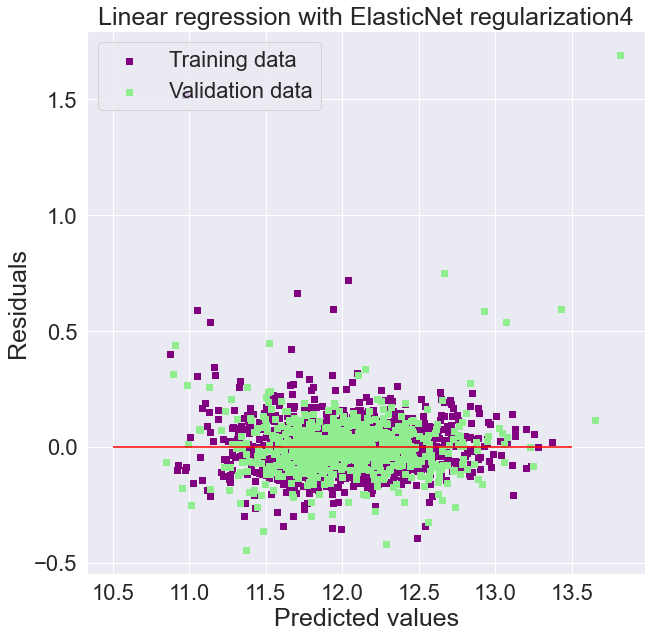

In [138]:
y_train_ela4 = elasticNet4.predict(X4_train)
y_test_ela4 = elasticNet4.predict(X4_test)

# Plot residuals
plt.scatter(y_train_ela4, y_train_ela4 - Y4_train, c = "purple", marker = "s", label = "Training data")
plt.scatter(y_test_ela4, y_test_ela4 - Y4_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization4", fontsize=25)
plt.xlabel("Predicted values", fontsize=25)
plt.ylabel("Residuals", fontsize=25)
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

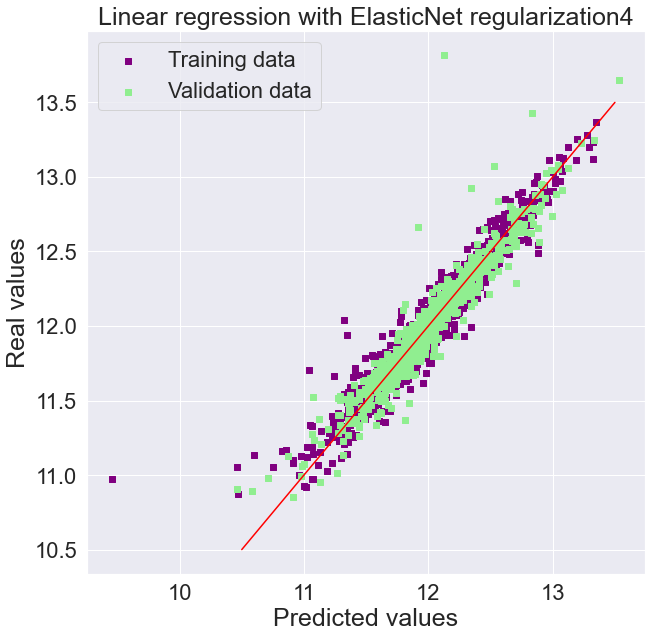

In [139]:
plt.scatter(Y4_train, y_train_ela4, c = "purple", marker = "s", label = "Training data")
plt.scatter(Y4_test, y_test_ela4, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization4",fontsize=25)
plt.xlabel("Predicted values", fontsize=25)
plt.ylabel("Real values", fontsize=25)
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

ElasticNet picked 142 features and eliminated the other 22 features


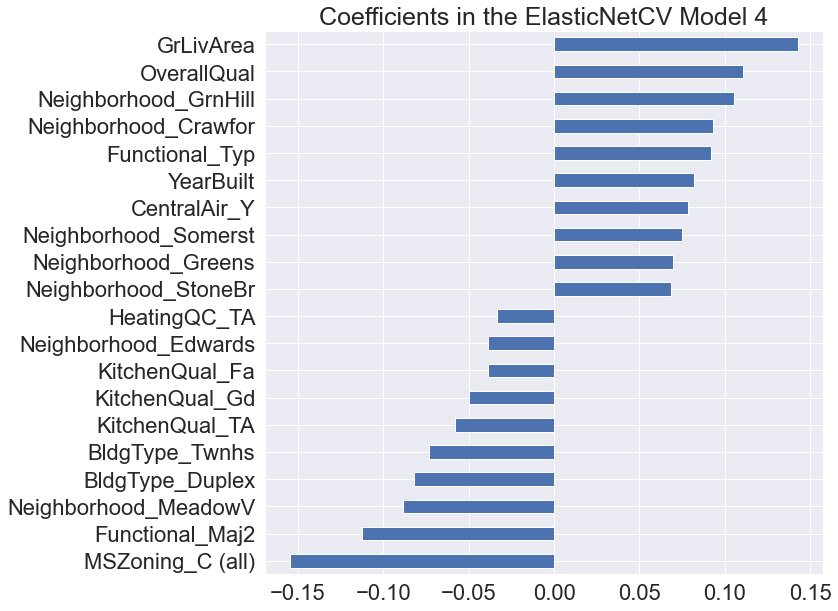

In [140]:
coefs4 = pd.Series(elasticNet4.coef_, index = X4_train.columns)
print("ElasticNet picked " + str(sum(coefs4 != 0)) + " features and eliminated the other " +  str(sum(coefs4 == 0)) + " features")
imp_coefs = pd.concat([coefs4.sort_values().head(10),
                     coefs4.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNetCV Model 4", fontsize=25)
plt.show()